# Load libraries

In [1]:
LS = !ls
IS_KAGGLE = 'init.sh' not in LS
IS_KAGGLE

False

In [2]:
import sys

class CFG:
    seed = 4121995

if IS_KAGGLE:
    sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
    CFG.frames_path = ''
    CFG.utils_path = '/kaggle/input/nflutils'
    
    sys.path.insert(0, '../input/nflutils')
    !mkdir -p nflutils
    !cp ../input/nflutils/*.py nflutils/
    
else:
    CFG.frames_path = 'frames/content/work/frames/train'
    CFG.utils_path = 'nflutils'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle
import timm
import cv2

from pathlib import Path

from nflutils.dataprep import *

from tqdm.notebook import tqdm

from sklearn.metrics import matthews_corrcoef

import albumentations as A
from albumentations.pytorch import ToTensorV2

from fastai.vision.all import *

pd.set_option('display.max_columns', 500)

# Read Files

In [4]:
if IS_KAGGLE:
    BASE_DIR = Path("../input/nfl-player-contact-detection")
    OUT_DIR = Path("/kaggle/working/")
else:
    BASE_DIR = Path("nfl-player-contact-detection")
    OUT_DIR = Path("nfl-player-contact-detection/frames")

In [5]:
ss = pd.read_csv(BASE_DIR/"sample_submission.csv")

# Player tracking data
te_tracking = pd.read_csv(
    BASE_DIR/"test_player_tracking.csv", parse_dates=["datetime"]
)

# Baseline helmet detection labels
te_helmets = pd.read_csv(BASE_DIR/"test_baseline_helmets.csv")

In [6]:
df_combo = pd.read_parquet(CFG.utils_path+'/df_combo.parquet')
df_combo_with_helmets = pd.read_parquet(CFG.utils_path+'/df_tracking_helmets_below_2.parquet')
df_combo_with_helmets['G_flag'] = np.where(df_combo_with_helmets.nfl_player_id_2 == 'G', 1, 0)

In [7]:
kf_dict = pickle.load(open('kf_dict', 'rb'))

# Playground

## OOF Semi-final models

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [9]:
def get_interpolated_player_helmets(helmets_df, player_id):
    player_helmets = pd.DataFrame()
    tmp_frames_df = pd.DataFrame({'frame': np.arange(player_helmets_df.frame.min(), tr_helmets.frame.max()+1)})

    for view in helmets_df.view.unique():
        player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
        player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        player_helmets_view['view'] = view
        player_helmets = pd.concat([player_helmets, player_helmets_view], axis=0)
        
    return player_helmets

In [10]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame

def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame

@functools.lru_cache(maxsize=1000)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    

def get_interpolated_player_helmets(helmets_df, tmp_frames_df, player_id, view):
    player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
    player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        
    return player_helmets_view

class NFL25DDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True, frames_offsets=[-6, 0, 6]):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in frames_df.game_play.unique()}
        self.frames_offsets = frames_offsets
        self.tmp_frames_df = pd.DataFrame({'frame': np.arange(270, 1500)})


        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_1_id, view)
        player_2_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_2_id, view)
        
        frames = []
                
        for frame_offset in [-6, 0, 6]:
            frame_no = int(row.frame + frame_offset)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            
            if os.path.exists(frame_path):
                frame = self.get_frame(frame_path)

                if self.helmets:
                    try:
                        player_1_frame_helmet = player_1_helmets.query('frame == @frame_no').iloc[0]
                        player_2_frame_helmet = player_2_helmets.query('frame == @frame_no').iloc[0]

                        frame = add_helmet(frame, player_1_frame_helmet)
                        frame = add_helmet(frame, player_2_frame_helmet)
                    except:
                        print(gp, player_1_id, view, frame_no)

                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

                frames.append(frame)
            
        if len(frames) < len(self.frames_offsets):
            frames = frames + frames[-1:]*(len(self.frames_offsets)-len(frames))
            
        frame = np.stack(frames, axis=-1)
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
            
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame

def crop_frames(frames, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frames = frames[:,
                            int(min_y):int(max_y), 
                            int(min_x):int(max_x),
                            :]
    return cropped_frames
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

In [11]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    # train_frames_df.loc[(train_frames_df.nfl_player_id_2 == "G") & (train_frames_df.contact == 1)] = 2
    # val_frames_df.loc[(val_frames_df.nfl_player_id_2 == "G") & (val_frames_df.contact == 1)] = 2
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [12]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

In [13]:
class FrameTrackingModel(nn.Module):
    def __init__(self, arch='convnext_tiny', pretrained=True, n_in=3, concat_pool=True, mlp_n=64):
        super(FrameTrackingModel, self).__init__()
        
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in)
        self.body = TimmBody(model, pretrained, n_in=n_in)
        
        self.pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.mlp = nn.Sequential(
            nn.Linear(18, mlp_n),
            nn.LayerNorm(mlp_n),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Linear(model.num_features*[1, 2][concat_pool]+mlp_n, 2)
        
    def forward(self, frame, feats):
        # print(frame.shape, feats.shape)
        x1 = self.body(frame)
        x1 = self.pool(x1)
        x1 = self.flatten(x1)
        x2 = self.mlp(feats)
        # print(x1.shape, x2.shape)
        return self.fc(torch.cat([x1, x2], dim=1))

### Training

I'll aim to train small models all the way, as they are better suited for submissions.

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-simple-model-reshuffle-and-offset-pp-sep-1'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [18]:
seed = 42
split = 0
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


SuggestedLRs(valley=0.00013182566908653826)

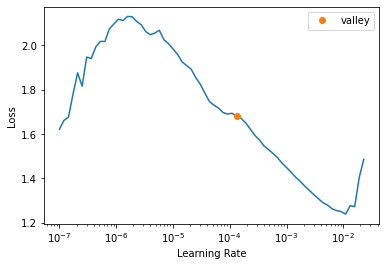

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.414397,0.359645,0.837355,0.553827,0.731477,0.589785,0.653034,12:04
1,0.404317,0.339387,0.840432,0.562942,0.740087,0.595520,0.659979,12:07
2,0.372629,0.404187,0.811884,0.572231,0.872369,0.530718,0.659948,12:04
3,0.322749,0.328101,0.850702,0.613325,0.821215,0.605645,0.697146,12:03
4,0.280067,0.357829,0.835724,0.616514,0.889838,0.568675,0.693897,12:06
5,0.257172,0.279295,0.881050,0.658145,0.777980,0.691891,0.732414,12:12
6,0.210414,0.313156,0.869124,0.645372,0.814491,0.649284,0.722564,12:04
7,0.175082,0.315135,0.875330,0.646491,0.779991,0.674859,0.723626,12:04
8,0.147763,0.316419,0.877171,0.647454,0.770502,0.683064,0.724153,12:05
9,0.154087,0.319520,0.878999,0.646882,0.755294,0.693657,0.723165,12:02


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5538268911146512.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.5629423524489231.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6133251648358851.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.6165144338669981.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6581447913515026.
49 7
50 8
51 9
52 10


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [23]:
val_games = kf_dict[0]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [26]:
preds, _ = learn.get_preds(dl=test_loader)

54 12


In [28]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [29]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6581873798653285

## Trying 2.5D.... Again

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [9]:
def get_interpolated_player_helmets(helmets_df, player_id):
    player_helmets = pd.DataFrame()
    tmp_frames_df = pd.DataFrame({'frame': np.arange(player_helmets_df.frame.min(), tr_helmets.frame.max()+1)})

    for view in helmets_df.view.unique():
        player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
        player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        player_helmets_view['view'] = view
        player_helmets = pd.concat([player_helmets, player_helmets_view], axis=0)
        
    return player_helmets

In [10]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame

def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame

@functools.lru_cache(maxsize=1000)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    

def get_interpolated_player_helmets(helmets_df, tmp_frames_df, player_id, view):
    player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
    player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        
    return player_helmets_view

class NFL25DDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True, frames_offsets=[-6, 0, 6]):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in frames_df.game_play.unique()}
        self.frames_offsets = frames_offsets
        self.tmp_frames_df = pd.DataFrame({'frame': np.arange(270, 1500)})


        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_1_id, view)
        player_2_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_2_id, view)
        
        frames = []
                
        for frame_offset in [-6, 0, 6]:
            frame_no = int(row.frame + frame_offset)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            
            if os.path.exists(frame_path):
                frame = self.get_frame(frame_path)

                if self.helmets:
                    try:
                        player_1_frame_helmet = player_1_helmets.query('frame == @frame_no').iloc[0]
                        player_2_frame_helmet = player_2_helmets.query('frame == @frame_no').iloc[0]

                        frame = add_helmet(frame, player_1_frame_helmet)
                        frame = add_helmet(frame, player_2_frame_helmet)
                    except:
                        print(gp, player_1_id, view, frame_no)

                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

                frames.append(frame)
            
        if len(frames) < len(self.frames_offsets):
            frames = frames + frames[-1:]*(len(self.frames_offsets)-len(frames))
            
        frame = np.stack(frames, axis=-1)
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
            
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame

def crop_frames(frames, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frames = frames[:,
                            int(min_y):int(max_y), 
                            int(min_x):int(max_x),
                            :]
    return cropped_frames
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

In [11]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    # train_frames_df.loc[(train_frames_df.nfl_player_id_2 == "G") & (train_frames_df.contact == 1)] = 2
    # val_frames_df.loc[(val_frames_df.nfl_player_id_2 == "G") & (val_frames_df.contact == 1)] = 2
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [12]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

In [13]:
class FrameTrackingModel(nn.Module):
    def __init__(self, arch='convnext_tiny', pretrained=True, n_in=3, concat_pool=True, mlp_n=64):
        super(FrameTrackingModel, self).__init__()
        
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in)
        self.body = TimmBody(model, pretrained, n_in=n_in)
        
        self.pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.mlp = nn.Sequential(
            nn.Linear(18, mlp_n),
            nn.LayerNorm(mlp_n),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Linear(model.num_features*[1, 2][concat_pool]+mlp_n, 2)
        
    def forward(self, frame, feats):
        # print(frame.shape, feats.shape)
        x1 = self.body(frame)
        x1 = self.pool(x1)
        x1 = self.flatten(x1)
        x2 = self.mlp(feats)
        # print(x1.shape, x2.shape)
        return self.fc(torch.cat([x1, x2], dim=1))

### Check the results of the latest best model on player to player only

In [14]:
tmp_df = pd.read_parquet('rgb-bbox-tracking-simple-model-with-reshuffle-and-offset.parquet')
tmp_df_p = tmp_df[tmp_df.nfl_player_id_2 != "G"]

matthews_corrcoef(tmp_df_p.contact, tmp_df_p.contact_pred > 0.5)

0.6253944977098744

So we need to exceed that in any way in order to have a better model. Let's do it.

### Training

I'll aim to train small models all the way, as they are better suited for submissions.

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-25D-with-reshuffle-and-offset-pp-sep'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [16]:
tr_helmets = pd.read_csv('nfl-player-contact-detection/train_baseline_helmets.csv')

In [17]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 != "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFL25DDataset, bs=30)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFL25DDataset),
                        # WandbCallback(log_preds=False, seed=seed),
                        # SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.0010000000474974513)

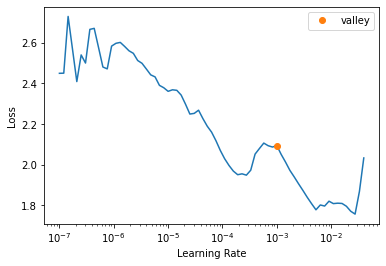

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.450774,0.464283,0.771329,0.508383,0.854999,0.477362,0.612663,47:20
1,0.408423,0.408952,0.801439,0.548512,0.851409,0.518659,0.644627,48:21
2,0.348993,0.383507,0.827006,0.574888,0.822515,0.562251,0.667925,48:53
3,0.300232,0.324965,0.850818,0.599291,0.779674,0.616519,0.688564,48:59
4,0.266212,0.352107,0.842777,0.593216,0.801977,0.595265,0.683330,48:35


58202_000546 43294 Endzone 434
58202_000546 43294 Endzone 440
58202_000546 43294 Endzone 446
58202_000546 43294 Endzone 446
58202_000546 43294 Endzone 452
58202_000546 43294 Endzone 458
58540_002206 43415 Endzone 404
58540_002206 43415 Endzone 410
58540_002206 43415 Endzone 416
43 1
58368_003010 35454 Endzone 421
58368_003010 35454 Endzone 427
58368_003010 35454 Endzone 433
58202_000546 43294 Endzone 445
58202_000546 43294 Endzone 451
58202_000546 43294 Endzone 457
58540_002206 43415 Endzone 404
58540_002206 43415 Endzone 410
58540_002206 43415 Endzone 416
44 2
58540_002206 43415 Endzone 404
58540_002206 43415 Endzone 410
58540_002206 43415 Endzone 416
45 3
58565_003743 41338 Endzone 353
58565_003743 41338 Endzone 359
58565_003743 41338 Endzone 365
58202_000546 43294 Endzone 449
58202_000546 43294 Endzone 455
58202_000546 43294 Endzone 461
58565_001768 41233 Endzone 437
58565_001768 41233 Endzone 443
58565_001768 41233 Endzone 449
58540_002206 43415 Endzone 404
58540_002206 43415 Endzo

In [17]:
torch.save(learn.model, f'nflutils/{name}.pkl')

## Training player-player

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [9]:
def get_interpolated_player_helmets(helmets_df, player_id):
    player_helmets = pd.DataFrame()
    tmp_frames_df = pd.DataFrame({'frame': np.arange(player_helmets_df.frame.min(), tr_helmets.frame.max()+1)})

    for view in helmets_df.view.unique():
        player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
        player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        player_helmets_view['view'] = view
        player_helmets = pd.concat([player_helmets, player_helmets_view], axis=0)
        
    return player_helmets

In [10]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame

def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame

@functools.lru_cache(maxsize=1000)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    

def get_interpolated_player_helmets(helmets_df, tmp_frames_df, player_id, view):
    player_helmets_view = helmets_df.query('nfl_player_id == @player_id and view == @view')
    player_helmets_view = pd.merge(tmp_frames_df, player_helmets_view[['frame', 'left', 'width', 'top', 'height']], how='left', on='frame').interpolate(limit_direction='both')
        
    return player_helmets_view

class NFL25DDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True, frames_offsets=[-6, 0, 6]):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in frames_df.game_play.unique()}
        self.frames_offsets = frames_offsets
        self.tmp_frames_df = pd.DataFrame({'frame': np.arange(270, 1500)})


        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_1_id, view)
        player_2_helmets = get_interpolated_player_helmets(self.gps_helmet_dfs[gp], self.tmp_frames_df, player_2_id, view)
        
        frames = []
                
        for frame_offset in [-6, 0, 6]:
            frame_no = int(row.frame + frame_offset)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            
            if os.path.exists(frame_path):
                frame = self.get_frame(frame_path)

                if self.helmets:
                    try:
                        player_1_frame_helmet = player_1_helmets.query('frame == @frame_no').iloc[0]
                        player_2_frame_helmet = player_2_helmets.query('frame == @frame_no').iloc[0]

                        frame = add_helmet(frame, player_1_frame_helmet)
                        frame = add_helmet(frame, player_2_frame_helmet)
                    except:
                        print(gp, player_1_id, view, frame_no)

                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

                frames.append(frame)
            
        if len(frames) < len(self.frames_offsets):
            frames = frames + frames[-1:]*(len(self.frames_offsets)-len(frames))
            
        frame = np.stack(frames, axis=-1)
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
            
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame

def crop_frames(frames, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frames = frames[:,
                            int(min_y):int(max_y), 
                            int(min_x):int(max_x),
                            :]
    return cropped_frames
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

In [11]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    # train_frames_df.loc[(train_frames_df.nfl_player_id_2 == "G") & (train_frames_df.contact == 1)] = 2
    # val_frames_df.loc[(val_frames_df.nfl_player_id_2 == "G") & (val_frames_df.contact == 1)] = 2
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [12]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

In [13]:
class FrameTrackingModel(nn.Module):
    def __init__(self, arch='convnext_tiny', pretrained=True, n_in=3, concat_pool=True, mlp_n=64):
        super(FrameTrackingModel, self).__init__()
        
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in)
        self.body = TimmBody(model, pretrained, n_in=n_in)
        
        self.pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.mlp = nn.Sequential(
            nn.Linear(18, mlp_n),
            nn.LayerNorm(mlp_n),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Linear(model.num_features*[1, 2][concat_pool]+mlp_n, 2)
        
    def forward(self, frame, feats):
        # print(frame.shape, feats.shape)
        x1 = self.body(frame)
        x1 = self.pool(x1)
        x1 = self.flatten(x1)
        x2 = self.mlp(feats)
        # print(x1.shape, x2.shape)
        return self.fc(torch.cat([x1, x2], dim=1))

### Training

I'll aim to train small models all the way, as they are better suited for submissions.

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-simple-model-reshuffle-and-offset-pp-sep-1'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [18]:
seed = 42
split = 0
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, bs=64)

model = FrameTrackingModel('convnext_tiny')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


SuggestedLRs(valley=0.00013182566908653826)

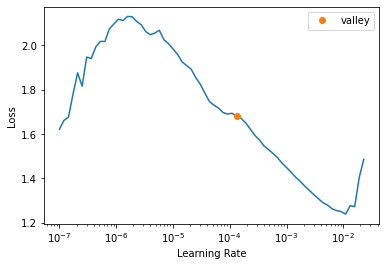

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(10, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.414397,0.359645,0.837355,0.553827,0.731477,0.589785,0.653034,12:04
1,0.404317,0.339387,0.840432,0.562942,0.740087,0.595520,0.659979,12:07
2,0.372629,0.404187,0.811884,0.572231,0.872369,0.530718,0.659948,12:04
3,0.322749,0.328101,0.850702,0.613325,0.821215,0.605645,0.697146,12:03
4,0.280067,0.357829,0.835724,0.616514,0.889838,0.568675,0.693897,12:06
5,0.257172,0.279295,0.881050,0.658145,0.777980,0.691891,0.732414,12:12
6,0.210414,0.313156,0.869124,0.645372,0.814491,0.649284,0.722564,12:04
7,0.175082,0.315135,0.875330,0.646491,0.779991,0.674859,0.723626,12:04
8,0.147763,0.316419,0.877171,0.647454,0.770502,0.683064,0.724153,12:05
9,0.154087,0.319520,0.878999,0.646882,0.755294,0.693657,0.723165,12:02


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5538268911146512.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.5629423524489231.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6133251648358851.
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.6165144338669981.
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6581447913515026.
49 7
50 8
51 9
52 10


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [23]:
val_games = kf_dict[0]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull())].copy()
val_df['frame'] = val_df['frame'].astype(int)

test_ds = NFLFrameTrackingDataset(val_df, transform=val_transform, crop_size=256)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [26]:
preds, _ = learn.get_preds(dl=test_loader)

54 12


In [28]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [29]:
matthews_corrcoef(val_df.contact, val_df.contact_pred > 0.5)

0.6581873798653285

In [30]:
tmp_df = pd.read_parquet('rgb-bbox-tracking-simple-model-with-reshuffle-and-offset.parquet')
tmp_df_p = tmp_df[(tmp_df.left_2.notnull())]

matthews_corrcoef(tmp_df_p.contact, tmp_df_p.contact_pred > 0.5)

0.6253944977098744

wandb: Waiting for W&B process to finish... (success).


#### Model with larger image size

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-simple-model-reshuffle-and-offset-pp-sep-2'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(p=0.2),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [21]:
seed = 42
split = 0
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, split, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameTrackingDataset, crop_size=320, bs=64)

model = FrameTrackingModel('convnext_small')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameTrackingDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # GradientAccumulation(90)
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.00010964782268274575)

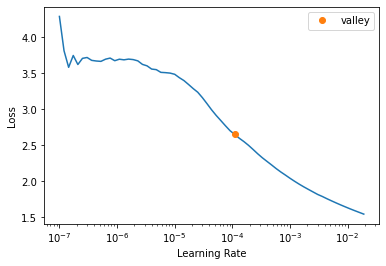

In [22]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

## Adding ground contact as a separate class

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [9]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame


@functools.lru_cache(maxsize=200)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

In [10]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    # train_frames_df.loc[(train_frames_df.nfl_player_id_2 == "G") & (train_frames_df.contact == 1)] = 2
    # val_frames_df.loc[(val_frames_df.nfl_player_id_2 == "G") & (val_frames_df.contact == 1)] = 2
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [11]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

#### Small model

In [12]:
import wandb
from fastai.callback.wandb import *

In [13]:
name = 'rgb-bbox-simple-model-with-reshuffle-and-offset-ground-sep'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [14]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [15]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.0002290867705596611)

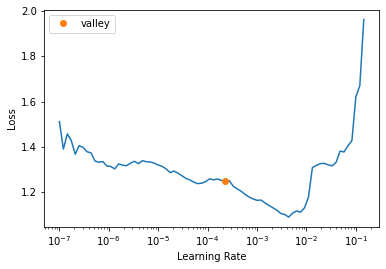

In [19]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.388888,0.170642,0.945217,0.535502,0.796942,0.391732,0.525270,08:40
1,0.287247,0.080102,0.973412,0.638856,0.656847,0.648535,0.652665,08:38
2,0.191157,0.141353,0.946714,0.565091,0.850911,0.404619,0.548446,08:39
3,0.167105,0.156650,0.942173,0.560391,0.879919,0.385859,0.536468,08:39
4,0.121445,0.082528,0.972685,0.674258,0.774455,0.611180,0.683198,08:41
5,0.109593,0.100721,0.962876,0.643927,0.860130,0.507025,0.637978,08:39
6,0.097060,0.090728,0.968341,0.654873,0.804587,0.558103,0.659053,08:39
7,0.087793,0.090044,0.970684,0.677302,0.823027,0.580860,0.681057,08:40
8,0.077739,0.072215,0.978355,0.694139,0.679559,0.732074,0.704840,08:40
9,0.060223,0.075360,0.975884,0.694273,0.757589,0.659167,0.704959,08:37


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5355023825169032.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.6388562176238892.
45 3


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



49 7
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.6773021520085495.
51 9
Better model found at epoch 8 with matthews_corrcoef value: 0.6941392457369616.
52 10
Better model found at epoch 9 with matthews_corrcoef value: 0.6942733549032405.


In [17]:
torch.save(learn.model, f'nflutils/{name}.pkl')

#### Bigger model

In [12]:
import wandb
from fastai.callback.wandb import *

In [13]:
name = 'rgb-bbox-simple-model-with-reshuffle-and-offset-ground-sep-bigger'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [15]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_base', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


SuggestedLRs(valley=9.120108734350652e-05)

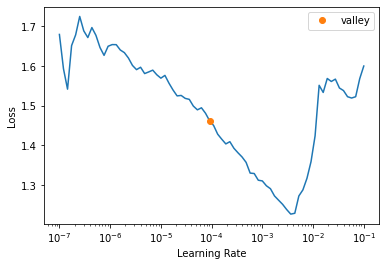

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.359907,0.128888,0.956976,0.561204,0.736676,0.459081,0.565657,14:13
1,0.273749,0.078200,0.971882,0.654702,0.736901,0.607414,0.665922,14:07
2,0.169398,0.141178,0.944242,0.567844,0.879469,0.395250,0.545391,14:11
3,0.139557,0.173803,0.932919,0.546370,0.919721,0.353287,0.510484,14:05
4,0.117380,0.069659,0.977432,0.706635,0.753542,0.684716,0.717482,14:07
5,0.097975,0.086049,0.969803,0.680284,0.847313,0.569184,0.680943,14:06
6,0.081051,0.076306,0.973327,0.689909,0.805487,0.613777,0.696684,14:04
7,0.083715,0.069520,0.977970,0.726026,0.801889,0.677818,0.734652,14:11
8,0.067613,0.066078,0.980527,0.722631,0.698673,0.768299,0.731834,14:10
9,0.045661,0.063741,0.980519,0.730551,0.731280,0.750173,0.740606,14:09


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.561203914916191.
44 2
Better model found at epoch 1 with matthews_corrcoef value: 0.6547023387757749.
45 3
46 4
47 5
Better model found at epoch 4 with matthews_corrcoef value: 0.7066346858953763.
48 6
49 7
50 8
Better model found at epoch 7 with matthews_corrcoef value: 0.7260259759869202.
51 9
52 10
Better model found at epoch 9 with matthews_corrcoef value: 0.730551058581839.


In [18]:
torch.save(learn.model, f'nflutils/{name}.pkl')

##### Combine this model with best model for players so far and check validation

In [19]:
kf_dict = pickle.load(open('kf_dict', 'rb'))
val_games = kf_dict[0]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

In [21]:
test_ds = NFLFrameDataset(val_df, val_transform, 256)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [22]:
preds, _ = learn.get_preds(dl=test_loader, with_loss=False)

53 11


In [24]:
val_df['contact_pred'] = preds[:, 1]

val_df.to_parquet(f'{name}.parquet', index=False)

In [25]:
from nflutils.validation import *

In [26]:
ws = list(np.arange(56, 76, 2))
tmp_df = smooth_predictions(val_df, center=True, ws=ws)
tmp_df.to_parquet(f'{name}-rolling.parquet', index=False)

  0%|          | 0/2054 [00:00<?, ?it/s]

In [27]:
tmp_df_g = tmp_df[tmp_df.nfl_player_id_2 == "G"].copy()
df_combo_g = df_combo[df_combo.nfl_player_id_2 == "G"]

cols = tmp_df_g.columns[tmp_df_g.columns.str.contains('rolling')]

cols_results = []

for col in tqdm(cols):
        
    for t in np.linspace(0.2, 0.4, 8):
        
        result = {}
    
        result['col'] = col
        
        result['thresh'] = t

        result['full'] = matthews_corrcoef(tmp_df_g["contact"], (tmp_df_g[col] > t).astype(int))

        agg_dict = {col: 'first' for col in val_df.columns}
        agg_dict[col] = 'mean'

        tmp_df_2 = tmp_df_g.groupby('contact_id').agg(agg_dict)

        result['average'] = matthews_corrcoef(tmp_df_2["contact"], (tmp_df_2[col] > t).astype(int))
        
        sub = tmp_df_g.copy()

        sub['contact_pred_rolling'] = sub[col]
        sub['thresh'] = t

        sub = merge_combo_val(df_combo_g, sub, pred_col='contact_pred_rolling')
        
        result['final'] = get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=1)
        cols_results.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
ground_results = pd.DataFrame(cols_results).sort_values('final', ascending=False)

In [29]:
ground_results.to_csv(f'{name}-ground-configs.csv', index=False)

In [30]:
ground_results.iloc[:10]

,col,thresh,full,average,final
7,contact_pred_rolling_56,0.400000,0.780388,0.819293,0.796737
15,contact_pred_rolling_58,0.400000,0.780293,0.818531,0.795998
31,contact_pred_rolling_62,0.400000,0.780980,0.817659,0.795155
23,contact_pred_rolling_60,0.400000,0.779895,0.817659,0.795155
22,contact_pred_rolling_60,0.371429,0.781046,0.817573,0.795047
38,contact_pred_rolling_64,0.371429,0.780199,0.816851,0.794349
14,contact_pred_rolling_58,0.371429,0.780596,0.816776,0.794276
30,contact_pred_rolling_62,0.371429,0.780330,0.816701,0.794203
61,contact_pred_rolling_70,0.342857,0.778777,0.816721,0.794196
45,contact_pred_rolling_66,0.342857,0.777588,0.816334,0.793825


In [31]:
name = 'rgb-bbox-tracking-simple-model-with-reshuffle-and-offset-even-bigger_5'
tmp_df2 = pd.read_parquet(f'{name}-rolling.parquet')

In [32]:
tmp_df_g = tmp_df[tmp_df.nfl_player_id_2 == "G"].copy()
tmp_df_p = tmp_df2[tmp_df2.nfl_player_id_2 != "G"].copy()

In [33]:
tmp_df_g['contact_pred_rolling'] = tmp_df_g.contact_pred_rolling_56
tmp_df_g['thresh'] = 0.4

In [34]:
tmp_df_p['contact_pred_rolling'] = tmp_df_p.contact_pred_rolling_22
tmp_df_p['thresh'] = 0.766667

In [35]:
cols = ['contact_id', 'distance', 'thresh', 'contact_pred_rolling', 'game_play', 'contact_pred']
sub_df = pd.concat([tmp_df_g[cols], tmp_df_p[cols]])

In [36]:
sub = merge_combo_val(df_combo, sub_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=0.5)

0.7609395489593282

In [49]:
tmp_df_g['contact_pred_rolling'] = tmp_df_g.contact_pred_rolling_56
tmp_df_g['thresh'] = 0.4

In [50]:
tmp_df_p['contact_pred_rolling'] = tmp_df_p.contact_pred_rolling_22
tmp_df_p['thresh'] = 0.73

In [51]:
cols = ['contact_id', 'distance', 'thresh', 'contact_pred_rolling', 'game_play', 'contact_pred']
sub_df = pd.concat([tmp_df_g[cols], tmp_df_p[cols]])

In [52]:
sub = merge_combo_val(df_combo, sub_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=0.5)

0.7593902121371636

In [53]:
tmp_df_g['contact_pred_rolling'] = tmp_df_g.contact_pred_rolling_56
tmp_df_g['thresh'] = 0.36

In [54]:
tmp_df_p['contact_pred_rolling'] = tmp_df_p.contact_pred_rolling_22
tmp_df_p['thresh'] = 0.73

In [55]:
cols = ['contact_id', 'distance', 'thresh', 'contact_pred_rolling', 'game_play', 'contact_pred']
sub_df = pd.concat([tmp_df_g[cols], tmp_df_p[cols]])

In [56]:
sub = merge_combo_val(df_combo, sub_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=0.5)

0.7591263956007127

In [57]:
tmp_df_g['contact_pred_rolling'] = tmp_df_g.contact_pred_rolling_56
tmp_df_g['thresh'] = 0.36

In [58]:
tmp_df_p['contact_pred_rolling'] = tmp_df_p.contact_pred_rolling_22
tmp_df_p['thresh'] = 0.766667

In [59]:
cols = ['contact_id', 'distance', 'thresh', 'contact_pred_rolling', 'game_play', 'contact_pred']
sub_df = pd.concat([tmp_df_g[cols], tmp_df_p[cols]])

In [60]:
sub = merge_combo_val(df_combo, sub_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=0.5)

0.760515870204295

In [61]:
sub.contact_pred.isna().sum()

832051

In [62]:
sub.shape

(948244, 15)

I seriously need a tabular model.

How many contacts is in this nulls?

In [63]:
sub[(sub.contact_pred.isna()) & (sub.contact == 1)].shape

(357, 15)

How many contacts in the opposite?

In [64]:
sub[(sub.contact_pred.notnull()) & (sub.contact == 1)].shape

(12129, 15)

How many of the nulls are player to player? and player to ground?

In [65]:
sub[(sub.contact_pred.isna()) & (sub.contact == 1) & (sub.nfl_player_id_2 != "G")].shape

(199, 15)

In [66]:
sub[(sub.contact_pred.isna()) & (sub.contact == 1) & (sub.nfl_player_id_2 == "G")].shape

(158, 15)

## Frame Pipeline with Tracking Data

The aim of this pipeline is to test if adding tracking data to the best model so far can get us better results.

First I'll create a dataloader that outputs the tracking data in addition to the imgs.

In [8]:
def get_frames_df(df_combo, kf_dict, split, frames_path, offset=0, sample_every_n_frame=None, sample_every_n_frame_train=None, sample_every_n_frame_val=None, sample_train=None, sample_val=None, undersample_no_contact=False, filter_views=None, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_every_n_frame is not None:
        train_combo = train_combo.query('(290 - frame - @offset) % @sample_every_n_frame == 0')
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame == 0')
        
    if sample_every_n_frame_train is not None:
        train_combo = train_combo.query('(290 - frame -@offset) % @sample_every_n_frame_train == 0')
        
    if sample_every_n_frame_val is not None:
        val_combo = val_combo.query('(290 - frame) % @sample_every_n_frame_val == 0')
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    frames_df = pd.concat([train_combo, val_combo], axis=0)
    frames_df.frame = frames_df.frame.astype('int') 
    
    if filter_views is not None:
        frames_df = frames_df.query('view in @filter_views')
        
    # frames_df['path'] = frames_df.apply(lambda x: get_frame_path(x, frames_path), axis=1)
        
    return frames_df


In [18]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame


@functools.lru_cache(maxsize=1000)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'

class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)


class NFLFrameTrackingDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.tracking_cols = ["x_position_1", "y_position_1", "speed_1", "distance_1", "direction_1", "orientation_1", "acceleration_1", "sa_1",
                              "x_position_2", "y_position_2", "speed_2", "distance_2", "direction_2", "orientation_2", "acceleration_2", "sa_2",
                              "distance", "G_flag"]
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
            
        tracking_data = row[self.tracking_cols].fillna(-1).values.astype(np.float32)
        
        return frame, tracking_data, row.contact
    
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[-1][i].item()])
        plt.axis("off")
    plt.show()

### First models

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [11]:
frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy(),
                          kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=None,
                          sample_val=None, undersample_no_contact=True).copy()

train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)

In [12]:
set_seed(42, True)

train_ds = NFLFrameTrackingDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFLFrameTrackingDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

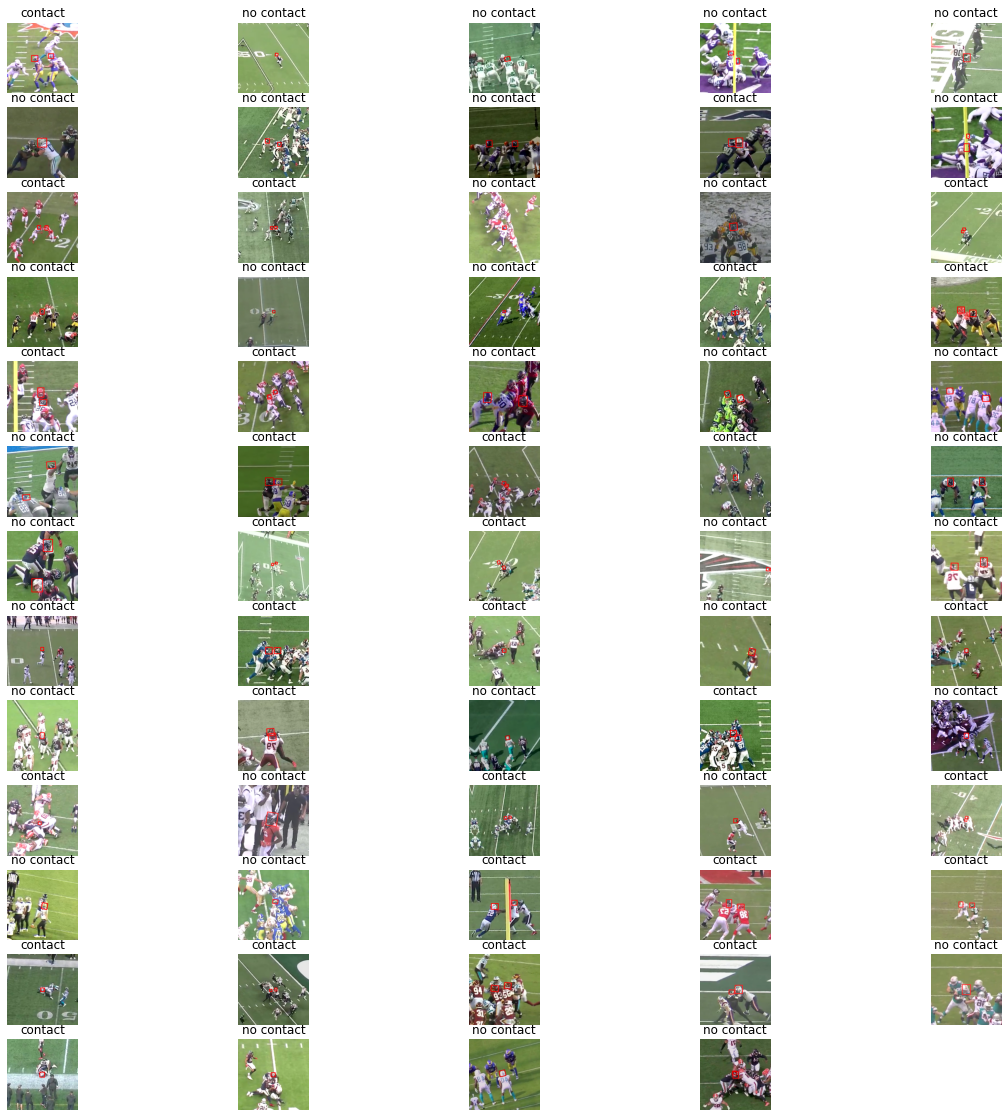

In [13]:
visualize_batch(next(iter(train_loader)), mean, std)

Now let's create the model.

In [10]:
class FrameTrackingModel(nn.Module):
    def __init__(self, arch='convnext_tiny', pretrained=True, n_in=3, concat_pool=True, mlp_n=64):
        super(FrameTrackingModel, self).__init__()
        
        model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in)
        self.body = TimmBody(model, pretrained, n_in=n_in)
        
        self.pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.mlp = nn.Sequential(
            nn.Linear(18, mlp_n),
            nn.LayerNorm(mlp_n),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Linear(model.num_features*[1, 2][concat_pool]+mlp_n, 2)
        
    def forward(self, frame, feats):
        # print(frame.shape, feats.shape)
        x1 = self.body(frame)
        x1 = self.pool(x1)
        x1 = self.flatten(x1)
        x2 = self.mlp(feats)
        # print(x1.shape, x2.shape)
        return self.fc(torch.cat([x1, x2], dim=1))

In [11]:
model = FrameTrackingModel()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [20]:
batch = next(iter(train_loader))

In [21]:
_ = model.forward(batch[0], batch[1])

torch.Size([64, 3, 256, 256]) torch.Size([64, 18])
torch.Size([64, 1536]) torch.Size([64, 64])


### Dataloaders test

So now the models is ready, and we just need to run it.

I want to test th batch prepartion runtime based on different number of workers.

In [23]:
def test_num_workers(n):
    train_loader = DataLoader(
        train_ds, batch_size=64, shuffle=True, num_workers=n
    )
    
    batch = next(iter(train_loader))

In [27]:
for i in range(9):
    print('-'*50, i, '-'*50)
    %timeit test_num_workers(i)

-------------------------------------------------- 0 --------------------------------------------------
1.44 s ± 99.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------------- 1 --------------------------------------------------
3.76 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------------- 2 --------------------------------------------------
3.75 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------------- 3 --------------------------------------------------
4.04 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------------- 4 --------------------------------------------------
4.43 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------------- 5 --------------------------------------------------
4.94 s ± 372 ms per loop (mean ± std. de

In [38]:
def test_num_workers(n, m):
    train_loader = DataLoader(
        train_ds, batch_size=64, shuffle=True, num_workers=n
    )
    
    for i, b in enumerate(tqdm(train_loader)):
        time.sleep(1)
        if i == m:
            break

In [39]:
for i in range(2, 9):
    print('-'*50, i, '-'*50)
    test_num_workers(i, 20)

-------------------------------------------------- 2 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 3 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 4 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 5 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 6 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 7 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

-------------------------------------------------- 8 --------------------------------------------------


  0%|          | 0/2653 [00:00<?, ?it/s]

### Training

And finally let's start model training.

#### Simple Model

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-tracking-simple-model'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [17]:
learn.fine_tune(5, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.326773,0.205588,0.911982,0.616370,0.786788,0.558854,0.653517,18:07


Better model found at epoch 0 with matthews_corrcoef value: 0.6163702042595065.
Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.243917,0.209765,0.906764,0.630152,0.853585,0.536538,0.658907,17:44
1,0.238229,0.267856,0.878393,0.596382,0.915864,0.461537,0.613772,17:45
2,0.186333,0.276468,0.883648,0.599620,0.900246,0.472982,0.620145,17:44
3,0.147446,0.233085,0.902867,0.627369,0.869204,0.523905,0.653762,17:44
4,0.101320,0.261601,0.905023,0.625972,0.853585,0.531029,0.654737,17:45


Better model found at epoch 0 with matthews_corrcoef value: 0.6301515582125284.


#### Simple model with splitting

I forgot to add splitting to the model, so I'll add it and run training again.

In [19]:
import wandb
from fastai.callback.wandb import *

In [20]:
name = 'rgb-bbox-tracking-simple-model-2'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

accuracy,█▇▁▂▆▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▇█▁▂▇▇
lr_0,▁▂▃▅▆▇█▂▂▂▃▃▃▄▄▄▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
matthews_corrcoef,▅█▁▂▇▇
mom_0,█▇▆▅▃▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
precision_score,█▆▁▂▅▆
raw_loss,█▇▇▄▅▄▄▄▅▃▂▃▂▄▄▃▃▂▄▃▄▄▄▅▂▂▄▂▃▅▂▃▂▂▂▃▁▃▂▁
recall_score,▁▅█▇▅▅
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [21]:
def model_splitter(model):
    return [params(model.body), params(model.pool)+params(model.mlp)+params(model.fc)]

In [25]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                splitter=model_splitter,
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [ ]:
learn.fine_tune(5, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.482738,0.532815,0.761269,0.402578,0.858644,0.288125,0.431468,15:40


Better model found at epoch 0 with matthews_corrcoef value: 0.4025778734579296.
Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.380898,0.304562,0.875533,0.530723,0.783399,0.448538,0.570458,17:57
1,0.337798,0.213355,0.911210,0.587440,0.720285,0.561770,0.631228,18:01
2,0.296975,0.378040,0.845256,0.538948,0.914538,0.398348,0.554968,18:11


Better model found at epoch 0 with matthews_corrcoef value: 0.530722530765811.
Better model found at epoch 1 with matthews_corrcoef value: 0.5874398387699477.


### Simple model unfreezed trained for long epoch with custom lr

In [14]:
import wandb
from fastai.callback.wandb import *

In [13]:
name = 'rgb-bbox-tracking-simple-model-3'
# wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

In [14]:
def model_splitter(model):
    return params(model)

In [17]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                # splitter=model_splitter,
                cbs=[
                        # WandbCallback(log_preds=False, seed=seed),
                        # SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [18]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

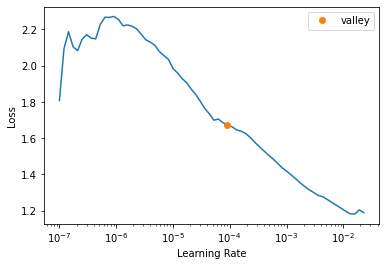

In [19]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(10, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.321684,0.211518,0.909432,0.597691,0.757515,0.551531,0.638316,40:27
1,0.310062,0.306505,0.856998,0.554219,0.906729,0.418057,0.572266,42:14
2,0.282699,0.212685,0.906189,0.627052,0.849411,0.534888,0.656418,44:13
3,0.236115,0.200173,0.913013,0.646276,0.855157,0.557170,0.674727,22:35
4,0.223410,0.235208,0.891814,0.609372,0.884381,0.492910,0.633011,23:33
5,0.195212,0.264220,0.881933,0.602828,0.915128,0.469450,0.620560,25:39
6,0.148495,0.203877,0.916687,0.659512,0.864833,0.569212,0.686552,23:51
7,0.118761,0.230137,0.913930,0.648191,0.854077,0.560429,0.676773,17:54
8,0.089035,0.235254,0.917765,0.651685,0.837181,0.575845,0.682346,17:50
9,0.073830,0.246707,0.919381,0.653228,0.829715,0.582839,0.684703,17:42


Better model found at epoch 0 with matthews_corrcoef value: 0.5976908708294866.
Better model found at epoch 2 with matthews_corrcoef value: 0.6270523604286657.
Better model found at epoch 3 with matthews_corrcoef value: 0.6462757406670684.
Better model found at epoch 6 with matthews_corrcoef value: 0.6595116758158063.


In [19]:
learn = learn.load(name)

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

### Simple model on player contact only

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        A.RandomCrop(192, 192),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [13]:
frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy(),
                          kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=None,
                          sample_val=None, undersample_no_contact=True).copy()

train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)

In [14]:
set_seed(42, True)

train_ds = NFLFrameTrackingDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFLFrameTrackingDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [15]:
import wandb
from fastai.callback.wandb import *

In [17]:
name = 'rgb-bbox-tracking-pp-simple-model-4'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
def model_splitter(model):
    return params(model)

In [21]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                # splitter=model_splitter,
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [22]:
learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

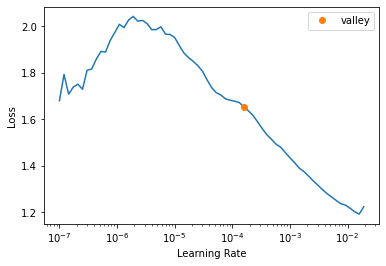

In [23]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.409026,0.414567,0.807111,0.536463,0.810344,0.525340,0.637435,08:21
1,0.389908,0.472918,0.760983,0.522678,0.910890,0.463781,0.614625,08:17
2,0.383513,0.408069,0.813923,0.563725,0.847232,0.534958,0.655819,08:16
3,0.367712,0.505841,0.761312,0.521727,0.908314,0.464058,0.614280,08:15
4,0.351530,0.381002,0.826743,0.599123,0.882172,0.554008,0.680597,08:19
5,0.332270,0.419103,0.797867,0.569249,0.908000,0.509539,0.652767,08:18
6,0.316720,0.284502,0.873700,0.645710,0.788161,0.667980,0.723111,08:17
7,0.306224,0.397042,0.821181,0.598402,0.899202,0.543986,0.677879,08:15
8,0.302700,0.332263,0.848821,0.627558,0.865142,0.595510,0.705439,08:17
9,0.287216,0.288977,0.871162,0.643512,0.797210,0.658773,0.721410,08:13


Better model found at epoch 0 with matthews_corrcoef value: 0.5364631372496077.
Better model found at epoch 2 with matthews_corrcoef value: 0.5637250072731816.
Better model found at epoch 4 with matthews_corrcoef value: 0.5991233592218682.
Better model found at epoch 6 with matthews_corrcoef value: 0.6457099143702828.


In [ ]:
learn = learn.load(name)

In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

Is this model better than the model that trained on both contacts in detection player-player one?

In [10]:
old_val_df = pd.read_parquet('rgb-bbox-tracking-simple-model-3.parquet')

In [12]:
pp_val_df = old_val_df[old_val_df.nfl_player_id_2 != "G"]

In [13]:
matthews_corrcoef(old_val_df.contact, old_val_df.contact_pred > 0.5)

0.658461997147887

So as it turns out, this one is actually worse, and the other one is better.

So let's test training a sample of the other on random crops to check it's performance and get back to it.

### Comparing total contact model with random crops

In [28]:
def random_crops_exp(name, epochs=10, lr=2e-3, random_crop=None, sample_train=0.1, sample_val=None):
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    if random_crop is not None:

        train_transform = A.Compose(
            [
                A.HorizontalFlip(),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.Normalize(mean=mean, std=std),
                A.RandomCrop(192, 192),
                ToTensorV2(),
            ]
        )
        
    else:
        
        train_transform = A.Compose(
            [
                A.HorizontalFlip(),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    val_transform = A.Compose(
        [
            A.Normalize(mean=mean, std=mean),
            ToTensorV2(),
        ]
    )
    
    frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy(),
                          kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=sample_train,
                          sample_val=sample_val, undersample_no_contact=True).copy()

    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    set_seed(42, True)

    train_ds = NFLFrameTrackingDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
    val_ds = NFLFrameTrackingDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

    train_loader = DataLoader(
        train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
    )
    
    
    seed = 42
    set_seed(42, True)

    data = DataLoaders(train_loader, val_loader)
    model = FrameTrackingModel()
    learn = Learner(data, model, CrossEntropyLossFlat(),
                    metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                    # splitter=model_splitter,
                    cbs=[
                            WandbCallback(log_preds=False, seed=seed),
                            SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                            # MixUp()
                    ]
                   ).to_fp16()
    
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, lr)

In [22]:
import wandb
from fastai.callback.wandb import *

#### Without Random Crops

In [29]:
name = 'without-random-crops'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

random_crops_exp(name, random_crop=None, sample_train=0.1, sample_val=0.1)

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
mom_0,██████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
raw_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,█▄▁▄▅▁▅▅▄▃▄▄▄▄▃▄▄▄▄▃▃▃▃▃▃▃▂▂▃▃▃▃▃▁▃▃▃▃▃▃
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1.0
eps_0,1e-05


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.458677,0.575108,0.748264,0.419438,0.918508,0.285083,0.435116,02:20
1,0.413528,0.356506,0.852316,0.492889,0.793814,0.399555,0.531558,02:22
2,0.380444,0.300419,0.871904,0.536038,0.810015,0.441767,0.571726,02:23
3,0.370566,0.250011,0.895741,0.547814,0.722631,0.504282,0.594027,02:20
4,0.329978,0.196737,0.915483,0.588500,0.691213,0.584232,0.633236,02:25
5,0.281984,0.281882,0.870142,0.560547,0.870398,0.441594,0.585922,02:28
6,0.239782,0.236108,0.897813,0.598535,0.828179,0.509822,0.631126,02:21
7,0.176754,0.253458,0.897554,0.596262,0.824251,0.509096,0.629428,02:23
8,0.119925,0.292362,0.897917,0.596048,0.821797,0.510210,0.629560,02:21
9,0.108335,0.312927,0.897451,0.594554,0.820815,0.508825,0.628217,02:20


Better model found at epoch 0 with matthews_corrcoef value: 0.419438102765421.
Better model found at epoch 1 with matthews_corrcoef value: 0.49288879713870176.
Better model found at epoch 2 with matthews_corrcoef value: 0.5360382492181773.
Better model found at epoch 3 with matthews_corrcoef value: 0.547814027387027.
Better model found at epoch 4 with matthews_corrcoef value: 0.5884995465861752.
Better model found at epoch 6 with matthews_corrcoef value: 0.5985349746959365.


#### With 192 Random Crops

In [30]:
name = '192-random-crops'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

random_crops_exp(name, random_crop=192, sample_train=0.1, sample_val=0.1)

accuracy,▁▅▆▇█▆▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁▄▆▇█▆████
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
matthews_corrcoef,▁▄▆▆█▇████
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_score,▁▄▅▆█▅▆▆▆▆
raw_loss,█▆▆▅▅█▆▅▆▆▆▄▄▆▄▄▅▄▃▅▃▃▃▄▃▃▃▂▂▂▂▂▃▂▃▂▃▂▁▂
recall_score,█▄▅▂▁▇▅▅▅▅
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.449057,0.363676,0.874702,0.522574,0.769269,0.445804,0.564481,01:57
1,0.435505,0.715284,0.624935,0.335809,0.960236,0.214638,0.350852,01:55
2,0.405951,0.384226,0.839465,0.504519,0.861070,0.383891,0.531032,01:55
3,0.402471,0.274993,0.882475,0.527800,0.745704,0.464668,0.572559,01:58
4,0.356639,0.433636,0.799668,0.476735,0.917035,0.335669,0.491450,01:59
5,0.312365,0.429960,0.798217,0.485115,0.937653,0.336445,0.495204,01:56
6,0.268964,0.345788,0.841227,0.523486,0.894944,0.390113,0.543368,01:58
7,0.223622,0.282637,0.879158,0.572996,0.860088,0.461174,0.600411,01:55
8,0.176976,0.307794,0.877293,0.569358,0.860088,0.456845,0.596730,01:58
9,0.150392,0.339881,0.871230,0.558289,0.861070,0.443377,0.585350,01:57


Better model found at epoch 0 with matthews_corrcoef value: 0.5225744787786911.
Better model found at epoch 3 with matthews_corrcoef value: 0.5277999229862733.
Better model found at epoch 7 with matthews_corrcoef value: 0.5729960018613244.


#### With 224 Random Crops

In [31]:
name = '224-random-crops'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

random_crops_exp(name, random_crop=224, sample_trثain=0.1, sample_val=0.1)

accuracy,█▁▇█▆▆▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▇▁▆▇▅▅▆███
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
matthews_corrcoef,▇▁▆▇▅▅▇███
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_score,▇▁▆█▄▄▆██▇
raw_loss,█▆▅▄▅▅▅▄▅▄▅▃▃▅▂▅▄▃▃▆▂▂▂▄▂▃▃▂▂▂▂▂▄▁▄▃▂▃▁▁
recall_score,▂█▅▁▇▇▆▅▅▅
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.449057,0.363676,0.874702,0.522574,0.769269,0.445804,0.564481,01:57
1,0.435505,0.715284,0.624935,0.335809,0.960236,0.214638,0.350852,01:57
2,0.405951,0.384226,0.839465,0.504519,0.861070,0.383891,0.531032,01:57
3,0.402471,0.274993,0.882475,0.527800,0.745704,0.464668,0.572559,01:56
4,0.356639,0.433636,0.799668,0.476735,0.917035,0.335669,0.491450,01:57
5,0.312365,0.429960,0.798217,0.485115,0.937653,0.336445,0.495204,01:58
6,0.268964,0.345788,0.841227,0.523486,0.894944,0.390113,0.543368,01:57
7,0.223622,0.282637,0.879158,0.572996,0.860088,0.461174,0.600411,01:57
8,0.176976,0.307794,0.877293,0.569358,0.860088,0.456845,0.596730,01:57
9,0.150392,0.339881,0.871230,0.558289,0.861070,0.443377,0.585350,01:56


Better model found at epoch 0 with matthews_corrcoef value: 0.5225744787786911.
Better model found at epoch 3 with matthews_corrcoef value: 0.5277999229862733.
Better model found at epoch 7 with matthews_corrcoef value: 0.5729960018613244.


So it's obvious that random cropping hinders performance, now let's add another augmentation. Cutouts

In [35]:
def aug_exp(name, cutout_p, epochs=10, lr=2e-3, sample_train=0.1, sample_val=None):
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    train_transform = A.Compose(
        [
            A.HorizontalFlip(),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=mean, std=std),
            A.CoarseDropout(p=cutout_p),
            ToTensorV2(),
        ]
    )


    val_transform = A.Compose(
        [
            A.Normalize(mean=mean, std=mean),
            ToTensorV2(),
        ]
    )
    
    frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy(),
                          kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=sample_train,
                          sample_val=sample_val, undersample_no_contact=True).copy()

    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    set_seed(42, True)

    train_ds = NFLFrameTrackingDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
    val_ds = NFLFrameTrackingDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

    train_loader = DataLoader(
        train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
    )
    
    
    seed = 42
    set_seed(42, True)

    data = DataLoaders(train_loader, val_loader)
    model = FrameTrackingModel()
    learn = Learner(data, model, CrossEntropyLossFlat(),
                    metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                    # splitter=model_splitter,
                    cbs=[
                            WandbCallback(log_preds=False, seed=seed),
                            SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                            # MixUp()
                    ]
                   ).to_fp16()
    
    
    learn.unfreeze()
    learn.fit_one_cycle(epochs, lr)

In [33]:
name = 'cutout-0.1'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

aug_exp(name, 0.1, sample_train=0.1, sample_val=0.1)

accuracy,█▁▇█▆▆▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▇▁▆▇▅▅▆███
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
matthews_corrcoef,▇▁▆▇▅▅▇███
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_score,▇▁▆█▄▄▆██▇
raw_loss,█▆▅▄▅▅▅▄▅▄▅▃▃▅▂▅▄▃▃▆▂▂▂▄▂▃▃▂▂▂▂▂▄▁▄▃▂▃▁▁
recall_score,▂█▅▁▇▇▆▅▅▅
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.453011,0.376216,0.851954,0.487275,0.783505,0.397807,0.527691,02:23
1,0.415480,0.275934,0.892320,0.527623,0.696122,0.492875,0.577127,02:22
2,0.380356,0.277442,0.883304,0.556407,0.804615,0.469224,0.592767,02:23
3,0.387635,0.442159,0.812882,0.485322,0.899853,0.349809,0.503779,02:24
4,0.325557,0.193079,0.917763,0.578172,0.646048,0.603116,0.623845,02:23
5,0.284725,0.263450,0.880765,0.575946,0.859597,0.464950,0.603481,02:22
6,0.246940,0.289041,0.866048,0.552206,0.868434,0.432942,0.577821,02:21
7,0.191901,0.276599,0.886983,0.581197,0.842906,0.479877,0.611576,02:23
8,0.128590,0.298003,0.890973,0.584530,0.831124,0.490298,0.616758,02:22
9,0.104808,0.313962,0.891543,0.583842,0.826706,0.491822,0.616737,02:24


Better model found at epoch 0 with matthews_corrcoef value: 0.4872751277555475.
Better model found at epoch 1 with matthews_corrcoef value: 0.5276225537694462.
Better model found at epoch 2 with matthews_corrcoef value: 0.5564067048216169.
Better model found at epoch 4 with matthews_corrcoef value: 0.5781715936193799.
Better model found at epoch 7 with matthews_corrcoef value: 0.5811966670366384.
Better model found at epoch 8 with matthews_corrcoef value: 0.5845303390709176.


In [36]:
name = 'cutout-0.2'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

aug_exp(name, 0.2, sample_train=0.1, sample_val=0.1)

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▂▂▃▃▄▄▅▅▆▇█
mom_0,█████▇▇▆▆▅▅▄▄▃▂▁
raw_loss,▅▅▅██▃▂▃▄▄▃▁▁▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▆▅▅▇█▇▅▅▄▄▄▃▂▂▁▁
train_samples_per_sec,▃███▃▆▅▄▆▆▆▃▄▅▅▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0.06015
eps_0,1e-05


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.460333,0.610065,0.708985,0.389564,0.933726,0.257619,0.403822,02:23
1,0.421406,0.245172,0.898280,0.535743,0.680903,0.513704,0.585603,02:23
2,0.385764,0.310118,0.877604,0.541361,0.797251,0.454520,0.578966,02:23
3,0.372730,0.364954,0.860452,0.525292,0.832106,0.418932,0.557291,02:22
4,0.320710,0.233342,0.897088,0.571067,0.768287,0.508282,0.611806,02:22
5,0.274465,0.319240,0.856358,0.541541,0.881689,0.415068,0.564425,02:21
6,0.235285,0.263363,0.885739,0.581214,0.848797,0.476834,0.610630,02:20
7,0.170030,0.265794,0.896051,0.591140,0.820324,0.504681,0.624907,02:24
8,0.122713,0.314523,0.890610,0.585247,0.834561,0.489349,0.616948,02:24
9,0.104024,0.328542,0.891854,0.585381,0.828670,0.492703,0.617975,02:22


Better model found at epoch 0 with matthews_corrcoef value: 0.3895644099997437.
Better model found at epoch 1 with matthews_corrcoef value: 0.5357426928027608.
Better model found at epoch 2 with matthews_corrcoef value: 0.541360920968089.
Better model found at epoch 4 with matthews_corrcoef value: 0.5710672968080209.
Better model found at epoch 6 with matthews_corrcoef value: 0.5812137525190958.
Better model found at epoch 7 with matthews_corrcoef value: 0.5911400080337778.


In [37]:
name = 'cutout-0.3'
wandb.init(project='nfl-1st-and-future', group='frame-exps', name=name, force=True)

aug_exp(name, 0.3, sample_train=0.1, sample_val=0.1)

accuracy,▁█▇▇█▆████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁▇▇▆█▆████
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
matthews_corrcoef,▁▆▆▆▇▆████
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
precision_score,▁█▆▅█▅▇█▇▇
raw_loss,█▅▆▅▅▆▄▄▄▅▅▃▄▅▃▄▄▄▃▄▃▃▂▃▃▃▃▁▂▃▃▂▃▂▂▂▂▂▁▂
recall_score,█▁▄▅▃▇▆▅▅▅
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.458810,0.546508,0.735672,0.402291,0.909671,0.273708,0.420802,02:19
1,0.419184,0.354681,0.844854,0.488566,0.810506,0.387650,0.524460,02:22
2,0.393148,0.329527,0.856099,0.513278,0.822779,0.409580,0.546908,02:21
3,0.374976,0.407374,0.821432,0.499581,0.905253,0.361781,0.516961,02:22
4,0.342563,0.244420,0.890869,0.577635,0.815906,0.489832,0.612155,02:24
5,0.274776,0.285288,0.872163,0.560031,0.861070,0.445404,0.587113,02:22
6,0.234687,0.233679,0.897710,0.588843,0.806087,0.509780,0.624572,02:22
7,0.177984,0.279572,0.888486,0.580904,0.835052,0.483651,0.612532,02:24
8,0.122732,0.325894,0.884029,0.572448,0.837015,0.472168,0.603754,02:21
9,0.102431,0.332123,0.887657,0.575672,0.827197,0.481291,0.608523,02:20


Better model found at epoch 0 with matthews_corrcoef value: 0.40229139197474145.
Better model found at epoch 1 with matthews_corrcoef value: 0.4885658231738147.
Better model found at epoch 2 with matthews_corrcoef value: 0.5132783923225217.
Better model found at epoch 4 with matthews_corrcoef value: 0.5776347695031907.
Better model found at epoch 6 with matthews_corrcoef value: 0.5888428403871868.


#### Simple model on player contact without cropping

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [13]:
frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull())].copy(),
                          kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=None,
                          sample_val=None, undersample_no_contact=True).copy()

train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)

In [14]:
set_seed(42, True)

train_ds = NFLFrameTrackingDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFLFrameTrackingDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [15]:
import wandb
from fastai.callback.wandb import *

In [17]:
name = 'rgb-bbox-tracking-pp-simple-model-5'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

In [18]:
def model_splitter(model):
    return params(model)

In [19]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                # splitter=model_splitter,
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [20]:
learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

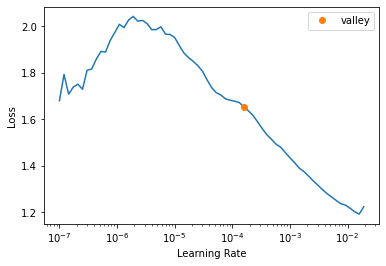

In [23]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(15, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.418623,0.326927,0.848387,0.575460,0.732860,0.615701,0.669191,12:25
1,0.400351,0.342786,0.844679,0.569983,0.737447,0.605865,0.665212,12:17
2,0.399413,0.290613,0.872963,0.593883,0.608936,0.738117,0.667332,12:17
3,0.348733,0.298367,0.868519,0.643046,0.811224,0.648563,0.720831,12:18
4,0.316057,0.436511,0.809820,0.587159,0.910513,0.526337,0.667066,12:16
5,0.312941,0.340262,0.843390,0.613422,0.853076,0.586469,0.695084,12:20
6,0.293064,0.266813,0.888690,0.650725,0.676805,0.764263,0.717880,12:17
7,0.269165,0.298638,0.870320,0.637633,0.784767,0.659868,0.716918,12:17
8,0.221115,0.318270,0.869663,0.632858,0.774461,0.660911,0.713194,12:16
9,0.201099,0.354111,0.858723,0.611876,0.777352,0.632058,0.697216,12:17


Better model found at epoch 0 with matthews_corrcoef value: 0.575460281793702.
Better model found at epoch 2 with matthews_corrcoef value: 0.5938829931025462.
Better model found at epoch 3 with matthews_corrcoef value: 0.6430463756911267.
Better model found at epoch 6 with matthews_corrcoef value: 0.6507248894363589.


### Resampling every epoch

Now I need to create a re-sampling scheme in each epoch from the non-contact data.

In [16]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [52]:
frames_kwargs = dict(frames_path=CFG.frames_path, offset=1, sample_every_n_frame=6, undersample_no_contact=True, seed=511)
data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs)

In [56]:
frames_kwargs = dict(frames_path=CFG.frames_path, offset=1, sample_every_n_frame=6, undersample_no_contact=False, seed=42)
frames_df = get_frames_df(df, kf_dict, 0, **frames_kwargs)
len(frames_df)

427269

In [57]:
frames_kwargs = dict(frames_path=CFG.frames_path, offset=1, sample_every_n_frame=6, undersample_no_contact=True, seed=42)
frames_df = get_frames_df(df, kf_dict, 0, **frames_kwargs)
len(frames_df)

218456

In [53]:
len(data.train)

2159

In [16]:
def get_dls(df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
    frames_df = get_frames_df(df_combo, kf_dict, split, **frames_kwargs).copy()
    
    train_frames_df = frames_df.query('~is_valid').copy().reset_index(drop=True)
    val_frames_df = frames_df.query('is_valid').copy().reset_index(drop=True)
    
    set_seed(frames_kwargs['seed'], True)

    train_ds = dl(train_frames_df, transform=train_transform, helmets=True, crop_size=crop_size)
    val_ds = dl(val_frames_df, transform=val_transform, helmets=True, crop_size=crop_size)

    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True,
    )
    
    data = DataLoaders(train_loader, val_loader, device=torch.device('cuda'))
    
    return data

In [17]:
class ShuffleGamePlayCallBack(Callback):
    def __init__(self, df_combo, kf_dict, split, train_transform, val_transform, frames_kwargs, crop_size=256, bs=64, num_workers=8, dl=NFLFrameTrackingDataset):
        self.df_combo = df_combo
        self.kf_dict = kf_dict
        self.split = split
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.crop_size = crop_size
        self.bs = bs
        self.num_workers = 8
        self.frames_kwargs = frames_kwargs
        self.dl = dl
        
    def after_epoch(self):
        self.frames_kwargs['seed'] += 1
        self.frames_kwargs['offset'] += 1
        print(self.frames_kwargs['seed'], self.frames_kwargs['offset'])
        self.learn.dls = get_dls(self.df_combo, self.kf_dict, self.split, self.train_transform,
                                 self.val_transform, self.frames_kwargs, self.crop_size, self.bs, self.num_workers, self.dl)

#### Testing the pipeline

In [69]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [70]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_train=0.01, sample_val=0.01, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs)

model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs)
                        # WandbCallback(log_preds=False, seed=seed),
                        # SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [71]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,1.085491,0.891087,0.231631,0.071767,1.000000,0.217005,0.356621,00:14
1,0.832520,0.659908,0.626401,0.247471,0.691860,0.325137,0.442379,00:14


#### Running the best model with reshuffling non-contact and offseting the frames every epoch

##### Small model

In [13]:
import wandb
from fastai.callback.wandb import *

In [19]:
name = 'rgb-bbox-tracking-simple-model-with-reshuffle-and-offset'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
raw_loss,█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,█▄▅▅▅▄▂▄▄▂▃▃▃▃▂▂▃▂▃▁▂▃▁▃▂▂▃▃▂▃▃▂▁▂▂▂▁▃▂▃
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0.18249
eps_0,1e-05


In [20]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [21]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs)

model = FrameTrackingModel()
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [22]:
learn.fit_one_cycle(10, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.321684,0.211518,0.909432,0.597691,0.757515,0.551531,0.638316,17:45
1,0.310514,0.259266,0.879813,0.567517,0.845236,0.461962,0.597410,17:48
2,0.293790,0.256648,0.895633,0.608848,0.863998,0.503132,0.635938,17:48
3,0.240307,0.259087,0.894068,0.604538,0.861935,0.498820,0.631930,17:43
4,0.226434,0.212231,0.906189,0.641566,0.884872,0.533396,0.665583,17:50
5,0.205920,0.203494,0.912925,0.655401,0.878782,0.555169,0.680459,17:46
6,0.171154,0.186674,0.920371,0.669693,0.866012,0.582472,0.696490,17:46
7,0.169498,0.177937,0.924061,0.672710,0.846906,0.599111,0.701777,17:46
8,0.148900,0.184241,0.925978,0.675965,0.840815,0.607854,0.705604,17:49
9,0.135449,0.187723,0.924672,0.674459,0.846955,0.601570,0.703478,17:44


Better model found at epoch 0 with matthews_corrcoef value: 0.5976908708294866.
Better model found at epoch 2 with matthews_corrcoef value: 0.6088477296415193.
Better model found at epoch 4 with matthews_corrcoef value: 0.641565571455602.
Better model found at epoch 5 with matthews_corrcoef value: 0.6554010796759843.
Better model found at epoch 6 with matthews_corrcoef value: 0.6696928021842089.
Better model found at epoch 7 with matthews_corrcoef value: 0.6727096036093809.
Better model found at epoch 8 with matthews_corrcoef value: 0.6759648736969088.


In [23]:
torch.save(learn.model, f'nflutils/{name}.pkl')

Next I should test if increasing the percentage of non-contact and using focal loss could improve

##### Bigger model

In [13]:
import wandb
from fastai.callback.wandb import *

In [14]:
name = 'rgb-bbox-tracking-simple-model-with-reshuffle-and-offset-bigger'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [43]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [52]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs)

model = FrameTrackingModel('convnext_small')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name, every_epoch=True, with_opt=True),
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

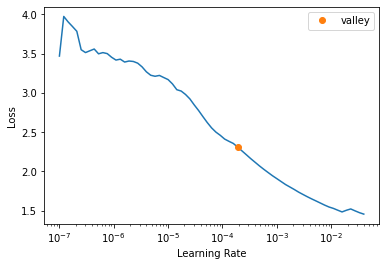

In [45]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 2e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.277773,0.249599,0.890617,0.600595,0.869941,0.489647,0.626607,28:59
1,0.286097,0.334790,0.854106,0.553287,0.914980,0.413491,0.569581,29:08
2,0.294028,0.216212,0.904562,0.614367,0.828193,0.530552,0.646772,29:06
3,0.257948,0.218849,0.910080,0.614244,0.794008,0.551270,0.650740,29:11
4,0.253448,0.209948,0.906313,0.634030,0.865717,0.534575,0.660992,28:49
5,0.224721,0.236635,0.897172,0.628732,0.902898,0.507117,0.649461,28:32
6,0.202013,0.251641,0.892871,0.620022,0.903978,0.495771,0.640352,28:20
7,0.221648,0.178710,0.923195,0.671386,0.849902,0.595253,0.700142,28:25
8,0.202596,0.183248,0.920724,0.660130,0.838163,0.587051,0.690485,28:52
9,0.182048,0.193375,0.918387,0.659125,0.852210,0.576598,0.687822,28:18


43 1
44 2
45 3
46 4
47 5
48 6
49 7
50 8
51 9
52 10
53 11


In [54]:
last_epoch = 10
learn = learn.load(f'{name}_{last_epoch}', device=torch.device('cuda'), with_opt=True)

In [55]:
learn.fit_one_cycle(20, 2e-3, start_epoch=last_epoch+1)

Could not gather input dimensions


43 1
44 2
45 3
46 4
47 5
48 6
49 7
50 8
51 9
52 10
53 11
54 12
55 13
56 14
57 15
58 16
59 17
60 18
61 19
62 20


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [ ]:
def smooth_predictions(val_df, center, ws):
    val_df_new = pd.DataFrame()
    for group, group_df in tqdm(val_df.groupby(['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'view'])):
        group_df = group_df.sort_values('frame').copy()
        for w in ws: 
            group_df[f'contact_pred_rolling_{w}'] = group_df.contact_pred.rolling(w, center=center).mean().bfill().ffill().fillna(0)
        val_df_new = pd.concat([val_df_new, group_df])
    return val_df_new

def merge_combo_val(df_combo, val_df, pred_col='contact_pred_rolling'):
    val_dist = df_combo[df_combo.game_play.isin(val_df.game_play.unique())].copy()

    val_dist["distance"] = val_dist["distance"].fillna(99)  # Fill player to ground with 9    
    val_dist_agg = val_dist.merge(val_df.groupby('contact_id', as_index=False)[pred_col].mean(), how='left', on='contact_id')
    val_dist_agg = val_dist_agg.merge(val_df.groupby('contact_id', as_index=False)['thresh'].first(), how='left', on='contact_id')
    
    if pred_col != 'contact_pred':
        val_dist_agg = val_dist_agg.merge(val_df.groupby('contact_id', as_index=False)['contact_pred'].mean(), how='left', on='contact_id')
        
    return val_dist_agg

def get_matthews_corrcoef(val_dist_agg, pred_col='contact_pred_rolling', dist=1):
    out = np.where(val_dist_agg['contact_pred'].isna(),
                   val_dist_agg['distance'] <= dist, 
                   val_dist_agg[pred_col] > val_dist_agg['thresh']).astype(int)
    
    return matthews_corrcoef(val_dist_agg['contact'], out)

def test_submission(val_df, w_p, w_g, thresh_p, thresh_g, dist=1):
    sub = val_df.copy()
    sub = sub[(sub.left_2.notnull()) | (sub.nfl_player_id_2 == "G")]

    sub = smooth_predictions(sub, True, ws=[w_p, w_g])
    sub['contact_pred_rolling'] = np.where(sub.nfl_player_id_2.notnull(), sub[f'contact_pred_rolling_{w_p}'], sub[f'contact_pred_rolling_{w_g}'])
    sub['thresh'] = np.where(sub.nfl_player_id_2.notnull(), thresh_p, thresh_g)
    
    sub = merge_combo_val(df_combo, sub, pred_col='contact_pred_rolling')
    return get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=dist)

In [ ]:
kf_dict = pickle.load(open('kf_dict', 'rb'))
val_games = kf_dict[0]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull()) | (val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

In [ ]:
tmp_df = smooth_predictions(val_df, True, [69, 18])

In [ ]:
tmp_df_g = tmp_df[tmp_df.nfl_player_id_2 == "G"].copy()
tmp_df_p = tmp_df[tmp_df.nfl_player_id_2 != "G"].copy()

In [ ]:
tmp_df_g['contact_pred_rolling'] = tmp_df_g.contact_pred_rolling_69
tmp_df_g['thresh'] = 0.4

In [ ]:
tmp_df_p['contact_pred_rolling'] = tmp_df_p.contact_pred_rolling_18
tmp_df_p['thresh'] = 0.7

In [ ]:
cols = ['contact_id', 'distance', 'thresh', 'contact_pred_rolling', 'game_play', 'contact_pred']
sub_df = pd.concat([tmp_df_g[cols], tmp_df_p[cols]])

In [56]:
sub = merge_combo_val(df_combo, sub_df, pred_col='contact_pred_rolling')
get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=0.5)

NameError: name 'merge_combo_val' is not defined

##### Even Bigger model

In [13]:
import wandb
from fastai.callback.wandb import *

In [14]:
name = 'rgb-bbox-tracking-simple-model-with-reshuffle-and-offset-even-bigger'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
class CutMix(MixHandler): 
    "Implementation of https://arxiv.org/abs/1905.04899"
    def __init__(self, 
        alpha:float=1. # Determine `Beta` distribution in range (0.,inf]
    ): 
        super().__init__(alpha)
        
    def before_batch(self):
        "Add `rand_bbox` patches with size based on `lam` and location chosen randomly."
        bs, _, H, W = self.x[0].size()
        self.lam = self.distrib.sample((1,)).to(self.x[0].device)
        shuffle = torch.randperm(bs).to(self.x[0].device)
        xb1,self.yb1 = self.x[0][shuffle], tuple((self.y[shuffle],))
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def rand_bbox(self, 
        W:int, # Width bbox will be
        H:int, # Height bbox will be
        lam:Tensor # lambda sample from Beta distribution i.e tensor([0.3647])
    )->tuple: # Represents the top-left pixel location and the bottom-right pixel location
        "Give a bounding box location based on the size of the im and a weight"
        cut_rat = torch.sqrt(1. - lam).to(self.x[0].device)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.x[0].device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.x[0].device)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x[0].device)
        cy = torch.randint(0, H, (1,)).to(self.x[0].device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [15]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [19]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs)

model = FrameTrackingModel('convnext_base')
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name, every_epoch=True, with_opt=True),
                        # CutMix()
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

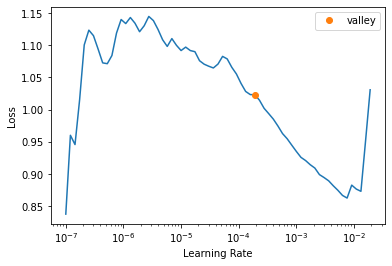

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(9, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.298843,0.291840,0.868387,0.572872,0.904519,0.439827,0.591859,39:01
1,0.274795,0.263099,0.881549,0.591366,0.890914,0.467777,0.613457,39:17
2,0.262382,0.250218,0.891006,0.612022,0.894450,0.490915,0.633911,38:57
3,0.210912,0.225754,0.908153,0.635223,0.857760,0.540798,0.663362,38:54
4,0.201508,0.162526,0.928377,0.678650,0.828585,0.620175,0.709390,38:59
5,0.156008,0.233066,0.907935,0.646211,0.886149,0.538712,0.670071,38:51
6,0.127803,0.199788,0.917822,0.659926,0.858202,0.573920,0.687846,38:54
7,0.121683,0.187802,0.927543,0.670383,0.812377,0.619406,0.702888,38:54
8,0.117528,0.191749,0.928693,0.672402,0.808153,0.625413,0.705136,38:56


43 1


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



46 4


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



50 8
51 9


In [54]:
last_epoch = 10
learn = learn.load(f'{name}_{last_epoch}', device=torch.device('cuda'), with_opt=True)

In [55]:
learn.fit_one_cycle(20, 2e-3, start_epoch=last_epoch+1)

Could not gather input dimensions


43 1
44 2
45 3
46 4
47 5
48 6
49 7
50 8
51 9
52 10
53 11
54 12
55 13
56 14
57 15
58 16
59 17
60 18
61 19
62 20


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

##### Small model rgb only

In [14]:
import wandb
from fastai.callback.wandb import *

In [15]:
name = 'rgb-bbox-simple-model-with-reshuffle-and-offset'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=mean),
        ToTensorV2(),
    ]
)

In [23]:
seed = 42
set_seed(seed, True)

df = df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy()

frames_kwargs = dict(frames_path=CFG.frames_path, offset=0, sample_every_n_frame=6, undersample_no_contact=True, seed=seed)

data = get_dls(df, kf_dict, 0, train_transform, val_transform, frames_kwargs=frames_kwargs, dl=NFLFrameDataset)

model, model_info = create_timm_model('convnext_tiny', 2)
learn = Learner(data, model, CrossEntropyLossFlat(),
                metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        ShuffleGamePlayCallBack(df, kf_dict, 0, train_transform, val_transform, frames_kwargs, dl=NFLFrameDataset),
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

SuggestedLRs(valley=0.0004786300996784121)

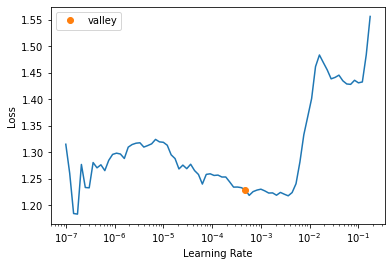

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(10, 4e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.380499,0.219247,0.912096,0.586298,0.711198,0.566422,0.630607,18:20
1,0.290474,0.283812,0.864921,0.552733,0.874116,0.430899,0.577244,18:22
2,0.290781,0.187578,0.921677,0.631302,0.753929,0.603025,0.670086,18:22
3,0.230520,0.204934,0.915790,0.636954,0.812917,0.570862,0.670719,18:19
4,0.221777,0.204880,0.908826,0.632614,0.847250,0.543564,0.662252,18:31
5,0.185121,0.203844,0.916158,0.640761,0.820138,0.571536,0.673632,18:21
6,0.162183,0.222374,0.905904,0.630941,0.860560,0.533510,0.658672,18:20
7,0.159483,0.208042,0.916620,0.629598,0.788163,0.576712,0.666058,18:23
8,0.146104,0.210111,0.917438,0.636311,0.799607,0.578680,0.671437,18:23
9,0.135386,0.204784,0.922377,0.642340,0.777947,0.602289,0.678940,18:21


43 1
Better model found at epoch 0 with matthews_corrcoef value: 0.5862980251989315.
45 3
Better model found at epoch 2 with matthews_corrcoef value: 0.6313020782984845.
46 4
Better model found at epoch 3 with matthews_corrcoef value: 0.6369541420307862.
47 5
48 6
Better model found at epoch 5 with matthews_corrcoef value: 0.6407611930702684.
49 7
50 8
51 9
52 10
Better model found at epoch 9 with matthews_corrcoef value: 0.6423396161594613.


In [ ]:
torch.save(learn.model, f'nflutils/{name}.pkl')

In [27]:
def smooth_predictions(val_df, center, ws):
    val_df_new = pd.DataFrame()
    for group, group_df in tqdm(val_df.groupby(['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'view'])):
        group_df = group_df.sort_values('frame').copy()
        for w in ws: 
            group_df[f'contact_pred_rolling_{w}'] = group_df.contact_pred.rolling(w, center=center).mean().bfill().ffill().fillna(0)
        val_df_new = pd.concat([val_df_new, group_df])
    return val_df_new

def merge_combo_val(df_combo, val_df, pred_col='contact_pred_rolling'):
    val_dist = df_combo[df_combo.game_play.isin(val_df.game_play.unique())].copy()

    val_dist["distance"] = val_dist["distance"].fillna(99)  # Fill player to ground with 9    
    val_dist_agg = val_dist.merge(val_df.groupby('contact_id', as_index=False)[pred_col].mean(), how='left', on='contact_id')
    val_dist_agg = val_dist_agg.merge(val_df.groupby('contact_id', as_index=False)['thresh'].first(), how='left', on='contact_id')
    
    if pred_col != 'contact_pred':
        val_dist_agg = val_dist_agg.merge(val_df.groupby('contact_id', as_index=False)['contact_pred'].mean(), how='left', on='contact_id')
        
    return val_dist_agg

def get_matthews_corrcoef(val_dist_agg, pred_col='contact_pred_rolling', dist=1):
    out = np.where(val_dist_agg['contact_pred'].isna(),
                   val_dist_agg['distance'] <= dist, 
                   val_dist_agg[pred_col] > val_dist_agg['thresh']).astype(int)
    
    return matthews_corrcoef(val_dist_agg['contact'], out)

def test_submission(val_df, w_p, w_g, thresh_p, thresh_g, dist=1):
    sub = val_df.copy()
    sub = sub[(sub.left_2.notnull()) | (sub.nfl_player_id_2 == "G")]

    sub = smooth_predictions(sub, True, ws=[w_p, w_g])
    sub['contact_pred_rolling'] = np.where(sub.nfl_player_id_2.notnull(), sub[f'contact_pred_rolling_{w_p}'], sub[f'contact_pred_rolling_{w_g}'])
    sub['thresh'] = np.where(sub.nfl_player_id_2.notnull(), thresh_p, thresh_g)
    
    sub = merge_combo_val(df_combo, sub, pred_col='contact_pred_rolling')
    return get_matthews_corrcoef(sub, pred_col='contact_pred_rolling', dist=dist)

In [28]:
kf_dict = pickle.load(open('kf_dict', 'rb'))
val_games = kf_dict[0]['val_games']

val_df = df_combo_with_helmets.query('game_play in @val_games').copy()
val_df = val_df[(val_df.left_2.notnull()) | (val_df.nfl_player_id_2 == "G")].copy()
val_df['frame'] = val_df['frame'].astype(int)

In [34]:
val_df = val_df.query('(290 - frame) % 6 == 0').copy()

In [29]:
preds, _ = learn.get_preds(dl=data.valid)

53 11


In [35]:
val_df.loc[:, 'contact_pred'] = preds[:, 1].cpu().detach().numpy()

In [36]:
val_df_g = val_df.query('nfl_player_id_2 == "G"')
val_df_p = val_df.query('nfl_player_id_2 != "G"')

In [39]:
matthews_corrcoef(val_df_g.contact, val_df_g.contact_pred > 0.5)

0.688223914542274

In [40]:
matthews_corrcoef(val_df_p.contact, val_df_p.contact_pred > 0.5)

0.5863259174161829

## 3D Pipeline

In [8]:
from torch.utils.data import Dataset, DataLoader
import functools

from decord import VideoReader
from decord import cpu, gpu

@functools.lru_cache(maxsize=1250)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'


def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame


class NFL3DDataset(Dataset):
    def __init__(self, steps_df, transform=None, crop_size=256, helmets=True):
        self.steps_df = steps_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in steps_df.game_play.unique()}
        
    def __len__(self):
        return len(self.steps_df)
        
    def __getitem__(self, idx):
        row = self.steps_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_1_id')
        player_2_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_2_id')
        
        frames = []
                
        for frame_no in row.frame:
            frame_no = int(frame_no)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            frame = self.get_frame(frame_path)
            
            if self.helmets:
                player_1_frame_helmet = player_1_helmets.query('frame == @frame_no and view == @view')
                player_2_frame_helmet = player_2_helmets.query('frame == @frame_no and view == @view')
                
                frame = add_helmet(frame, player_1_frame_helmet)
                frame = add_helmet(frame, player_2_frame_helmet)
                
                # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                
            frames.append(frame)
            
        if len(frames) < 6:
            frames = frames + frames[-1:]*(6-len(frames))
            
        frames = np.stack(frames, axis=0)
        frames = crop_frames(frames, row.center_x, row.center_y, self.crop_size)
        frames = torch.tensor(frames).permute(3, 0, 1, 2)
        
        if self.transform is not None:
            frames = self.transform(frames)
            
        return frames, row.contact
            
    def get_frame(self, path):
        return _get_frame(path)
    

# class NFL3DDataset(Dataset):
#     def __init__(self, steps_df, transform=None, crop_size=256, helmets=True, vids_path='nfl-player-contact-detection/train', views=['Sideline', 'Endzone'], h=720, w=1280):
#         self.steps_df = steps_df
#         self.helmets = helmets
#         self.crop_size = crop_size
#         self.transform = transform
#         self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in steps_df.game_play.unique()}
#         self.video_readers = self.get_video_readers(steps_df, vids_path, views, h, w)
        
#     def __len__(self):
#         return len(self.steps_df)
        
#     def __getitem__(self, idx):
#         row = self.steps_df.iloc[idx]
#         gp = row['game_play']
#         view = row['view']
                
#         player_1_id = int(row.nfl_player_id_1)
#         player_2_id = int(row.nfl_player_id_2)
        
#         player_1_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_1_id')
#         player_2_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_2_id')
        
#         frames = self.get_frames(gp, view, row.frame)
                
#         for i, (frame_no, frame) in enumerate(zip(row.frame, frames)):
            
#             if self.helmets:
#                 player_1_frame_helmet = player_1_helmets.query('frame == @frame_no and view == @view')
#                 player_2_frame_helmet = player_2_helmets.query('frame == @frame_no and view == @view')
                
#                 frames[i] = add_helmet(frame, player_1_frame_helmet)
#                 frames[i] = add_helmet(frame, player_2_frame_helmet)
                
#                 # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                            
#         if frames.shape[0] < 6:
            
#             frames = np.concatenate([frames] + [frames[-1][None,...] for _ in range(6-frames.shape[0])])
            
#         frames = crop_frames(frames, row.center_x, row.center_y, self.crop_size)
        
#         frames = torch.tensor(np.transpose(frames, (3, 0, 1, 2)))
                
#         if self.transform is not None:
#             frames = self.transform(frames)
                        
#         return frames, row.contact
    
    
#     def get_video_readers(self, steps_df, vids_path, views, h, w):
#         video_readers = {}
#         for gp in steps_df.game_play.unique():
#             for view in views:
#                 video_readers[(gp, view)] = VideoReader((BASE_DIR/'train'/f'{gp}_{view}.mp4').as_posix(), ctx=cpu(), height=h, width=w)
#         return video_readers
    
#     def get_frames(self, game_play, view, frames):
#         video_reader = self.video_readers[(game_play, view)]
#         frames = video_reader.get_batch(frames)
#         # video_reader.seek(0)
#         return frames.asnumpy()
    
    
    
def crop_frames(frames, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frames = frames[:,
                            int(min_y):int(max_y), 
                            int(min_x):int(max_x),
                            :]
    return cropped_frames
    
def visualize_vid_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()

     # Get batch channels no and time
    channels = batch_tensor.shape[1]

    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(std[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1, 1) + torch.tensor(mean[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1, 1)

    # Convert the data to numpy and transpose it to (batch_size, time, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 4, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    c = 1
    for i in range(batch_np.shape[0]):
        for j in range(batch_np.shape[1]):
            plt.subplot(batch_np.shape[0], batch_np.shape[1], c)
            plt.imshow(batch_np[i, j])
            c += 1
            plt.title(['no contact', 'contact'][batch[1][i].item()])
            plt.axis("off")
    plt.show()

In [9]:
def get_steps_df(df_combo, video_metadata, helmets, filter_views=None):    
    players_combo = df_combo.query('nfl_player_id_2 != "G" and distance <= 2').copy()
    
    if filter_views is not None:
        players_combo = players_combo.query('view in @filter_views').copy()

    players_tracking_helmets = pd.DataFrame()

    for gp in tqdm(players_combo.game_play.unique()):
        players_tracking_helmets = pd.concat([players_tracking_helmets,
                                              merge_tracking_and_helmets_ts(players_combo, helmets, video_metadata, gp, 'Sideline'),
                                              merge_tracking_and_helmets_ts(players_combo, helmets, video_metadata, gp, 'Endzone')])
        
    players_tracking_helmets = calc_two_players_helmets_center(players_tracking_helmets)
    
    players_tracking_helmets['left_1_na'] = players_tracking_helmets.left_1.isna()
    players_tracking_helmets['left_2_na'] = players_tracking_helmets.left_2.isna()
        
    agg_dict = {'game_play': 'first',
            'step': 'first',
            'nfl_player_id_1': 'first',
            'nfl_player_id_2': 'first',
            'contact': 'first',
            'distance': 'first',
            'frame': lambda x: list(x),
            'center_x': 'mean',
            'center_y': 'mean',
            'left_1_na': 'sum',
            'left_2_na': 'sum'}

    steps_df = players_tracking_helmets.groupby(['contact_id', 'view']).agg(agg_dict).reset_index()
    
    return steps_df

In [10]:
def split_df(df_combo, kf_dict, split, sample_train=None, sample_val=None, undersample_no_contact=False, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    return train_combo, val_combo

In [11]:
tr_helmets = pd.read_csv(BASE_DIR/"train_baseline_helmets.csv")

tr_video_metadata = pd.read_csv(
    BASE_DIR/"train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)

In [12]:
steps_df = get_steps_df(df_combo, tr_video_metadata, tr_helmets)

  0%|          | 0/240 [00:00<?, ?it/s]

In [13]:
steps_df = steps_df.query('left_1_na == 0 and left_2_na == 0')
steps_df['contact_id_view'] = steps_df['contact_id'] + steps_df['view']

In [14]:
train_steps_df, val_steps_df = split_df(steps_df, kf_dict, split=0, undersample_no_contact=True, seed=42)

In [15]:
train_steps_df.shape, val_steps_df.shape

((128878, 15), (75762, 15))

In [16]:
from pytorchvideo.transforms import (
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    CenterCrop,
    RandomHorizontalFlip
)

mean = (0.45, 0.45, 0.45)
std = (0.225, 0.225, 0.225)

train_transform = Compose(
    [
        # UniformTemporalSubsample(8),
        Lambda(lambda x: x / 255.0),
        Normalize(mean, std),
        # RandomShortSideScale(min_size=256, max_size=320),
        RandomCrop(244),
        RandomHorizontalFlip(p=0.5)
    ]
)

val_transform = Compose(
    [
        # UniformTemporalSubsample(8),
        Lambda(lambda x: x / 255.0),
        Normalize(mean, std),
        CenterCrop(244)
    ]
)

In [17]:
train_ds = NFL3DDataset(train_steps_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFL3DDataset(val_steps_df, transform=val_transform, helmets=True, crop_size=256)

In [18]:
x, _ = train_ds[0]
x.shape

torch.Size([3, 6, 244, 244])

In [19]:
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

In [58]:
%%time 

batch = next(iter(train_loader))

CPU times: user 139 ms, sys: 1.15 s, total: 1.29 s
Wall time: 10.8 s


In [35]:
def test_num_workers(n):
    train_loader = DataLoader(
        train_ds, batch_size=12, shuffle=True, num_workers=n
    )
    
    batch = next(iter(train_loader))

In [46]:
%timeit test_num_workers(0)

2.42 s ± 187 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit test_num_workers(1)

5.15 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit test_num_workers(2)

5.39 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit test_num_workers(3)

5.64 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit test_num_workers(4)

5.79 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit test_num_workers(5)

6.35 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit test_num_workers(6)

6.5 s ± 441 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%timeit test_num_workers(7)

6.8 s ± 324 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit test_num_workers(8)

7.45 s ± 535 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


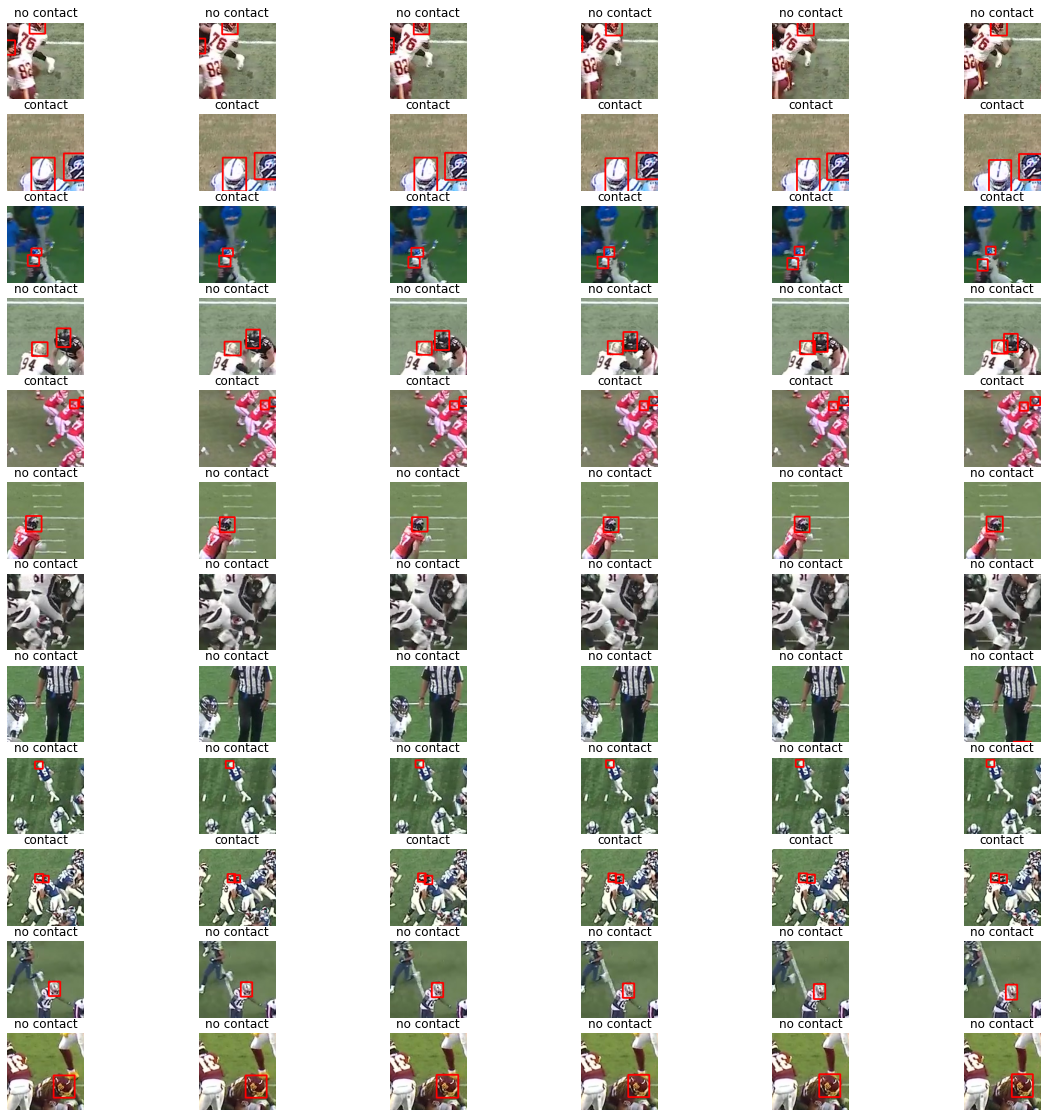

In [50]:
visualize_vid_batch(batch, mean, std)

In [21]:
import wandb
from fastai.callback.wandb import *

In [22]:
name = '3D-pp-nonulls-128'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
import pytorchvideo.models.resnet

def make_3D_resnet(in_c, depth, n_out):
    return pytorchvideo.models.resnet.create_resnet(
      input_channel=in_c, 
      model_depth=depth, 
      model_num_class=n_out, 
      norm=nn.BatchNorm3d,
      activation=nn.ReLU,
    )

In [24]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model = make_3D_resnet(3, 50, 2)
learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name, every_epoch=True),
                        # MixUp()
                ]
               ).to_fp16()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad1a6b49d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad1a6b49d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

SuggestedLRs(valley=5.248074739938602e-05)

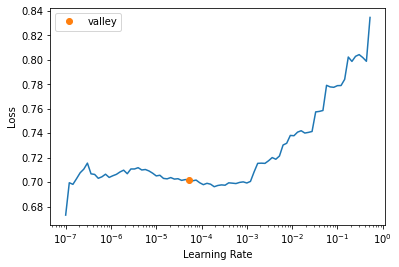

In [61]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 2e-4)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.607399,0.585363,0.699982,0.358600,0.745220,0.385275,0.507945,1:40:22
1,0.474199,0.455385,0.793656,0.499951,0.777870,0.502256,0.610393,1:41:09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad1a6b49d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad1a6b49d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [29]:
learn.load(f'{name}_2')

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
learn.fit_one_cycle(10, 2e-4, start_epoch=3)

Could not gather input dimensions


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
learn.load(f'{name}_4')

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
learn.fit_one_cycle(10, 2e-4, start_epoch=5)

Could not gather input dimensions


In [25]:
learn.load(f'{name}_7')

/usr/local/lib/python3.9/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [26]:
learn.fit_one_cycle(10, 2e-4, start_epoch=8)

Could not gather input dimensions


In [ ]:
learn.export(name)

AttributeError: 'DataLoader' object has no attribute 'new'

## New 2.5D pipeline

### Creating the dataframe 

The main idea behind this pipeline is use the total frames included in a step. 

Not only this, but also to incude other frames surrounding it at +-10Hz (6 frames in both directions).

In order to do this, I have to be able to select these frames, and impute any missing helmets during inference at least. So we can see two possibilities arising:
1. The first is to drop steps that having missing frames at all
2. The second is to drop steps that having missing frames over a threshold
3. The third is to use all

So I need to keep that in mind while training. First, let's try to create such a dataset, or see if it can be queried directly.

In [8]:
# Let's select a random step for example
df_combo_with_helmets.query('contact == 1').sample(n=1, random_state=42)

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,y_position_2,distance,datetime_ngs,view,frame,player_label_1,left_1,width_1,top_1,height_1,player_label_2,left_2,width_2,top_2,height_2,top,left,bottom,right,center_y,center_x
2389771,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,664.0,H54,823.0,22.0,317.0,18.0,V35,751.0,21.0,298.0,25.0,298.0,751.0,335.0,845.0,316.0,798.0


In [9]:
%%time 

# Let's filter all of it's steps 
df_combo_with_helmets.query('game_play == "58291_001043" and step == 62 and nfl_player_id_1 == "44974" and nfl_player_id_2 == "46437" and view == "Endzone"')

CPU times: user 337 ms, sys: 51.5 ms, total: 388 ms
Wall time: 348 ms


,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,y_position_2,distance,datetime_ngs,view,frame,player_label_1,left_1,width_1,top_1,height_1,player_label_2,left_2,width_2,top_2,height_2,top,left,bottom,right,center_y,center_x
2389771,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,664.0,H54,823.0,22.0,317.0,18.0,V35,751.0,21.0,298.0,25.0,298.0,751.0,335.0,845.0,316.0,798.0
2389772,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,665.0,H54,824.0,21.0,317.0,18.0,V35,750.0,21.0,297.0,24.0,297.0,750.0,335.0,845.0,316.0,797.0
2389773,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,666.0,H54,823.0,22.0,318.0,18.0,V35,748.0,21.0,296.0,24.0,296.0,748.0,336.0,845.0,316.0,796.0
2389774,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,667.0,H54,823.0,21.0,320.0,16.0,V35,746.0,21.0,295.0,24.0,295.0,746.0,336.0,844.0,315.0,795.0
2389775,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,668.0,H54,822.0,22.0,321.0,16.0,V35,745.0,22.0,295.0,23.0,295.0,745.0,337.0,844.0,316.0,794.0
2389776,58291_001043_62_44974_46437,58291_001043,2020-11-08 18:51:38.200000+00:00,62,44974,46437,1,46.31,40.02,46.28,38.95,1.07042,2020-11-08 18:51:38.200000+00:00,Endzone,669.0,H54,821.0,21.0,324.0,15.0,V35,743.0,21.0,297.0,23.0,297.0,743.0,339.0,842.0,318.0,792.0


There we have 6 frames, and this query is really expensive. Let's check querying the original dataframes.

In [10]:
tr_helmets = pd.read_csv(BASE_DIR/"train_baseline_helmets.csv")

In [11]:
%%time 

tr_helmets.query('game_play == "58291_001043" and (frame <= 668-6 or frame >= 668+6) and nfl_player_id == 44974 and view == "Sideline"')

CPU times: user 144 ms, sys: 23.1 ms, total: 168 ms
Wall time: 168 ms


,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
1402643,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,290,44974,H54,704,13,299,14
1402680,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,291,44974,H54,704,13,300,14
1402717,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,292,44974,H54,704,13,300,14
1402755,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,293,44974,H54,704,13,300,14
1402786,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,294,44974,H54,704,13,300,14
...,...,...,...,...,...,...,...,...,...,...,...,...
1424767,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,878,44974,H54,710,30,234,39
1424806,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,879,44974,H54,710,30,232,38
1424839,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,880,44974,H54,710,31,231,39
1424878,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,881,44974,H54,710,31,229,39


Still, that seems like a headache. But what if I already extract the game_play's bounding boxes?

In [12]:
gp_helmets = tr_helmets.query('game_play == "58291_001043"')

In [13]:
%%time

gp_helmets.query('game_play == "58291_001043" and (frame <= 668-6 or frame >= 668+6) and nfl_player_id == 44974 and view == "Sideline"')

CPU times: user 4.8 ms, sys: 405 µs, total: 5.2 ms
Wall time: 5.03 ms


,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
1402643,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,290,44974,H54,704,13,299,14
1402680,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,291,44974,H54,704,13,300,14
1402717,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,292,44974,H54,704,13,300,14
1402755,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,293,44974,H54,704,13,300,14
1402786,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,294,44974,H54,704,13,300,14
...,...,...,...,...,...,...,...,...,...,...,...,...
1424767,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,878,44974,H54,710,30,234,39
1424806,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,879,44974,H54,710,30,232,38
1424839,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,880,44974,H54,710,31,231,39
1424878,58291_001043,58291,1043,Sideline,58291_001043_Sideline.mp4,881,44974,H54,710,31,229,39


That's a really huge improvement, and that should remove the need to make a specialized dataset for this.

However, I need to go back and change the way I'm creating the dataset in the first place, to include all players, then calculate the number of missing bounding boxes in each window I'll be selecting.

In hindsight, I won't actually need any new datasets I'll only need df_combo since it has the distance, where I'll be able to drop pairs that have lower thresholds.

In [18]:
# Let's keep only the players combo df

players_combo = df_combo.query('nfl_player_id_2 != "G" and distance <= 2')

df_combo.shape, players_combo.shape

((4721618, 12), (249920, 12))

In [8]:
def merge_tracking_and_helmets_ts(tracking_df, helmets_df, meta_df, game_play, view, fps=59.94):
    gp_track = tracking_df.query('game_play == @game_play').copy()
    gp_helms = helmets_df.query('game_play == @game_play and view == @view').copy()
    
    start_time = meta_df.query("game_play == @game_play and view == @view")[
        "start_time"
    ].values[0]
    
    gp_helms["datetime"] = (
        pd.to_timedelta(gp_helms["frame"] * (1 / fps), unit="s") + start_time
    )
    gp_helms["datetime"] = pd.to_datetime(gp_helms["datetime"], utc=True)
    gp_helms["datetime_ngs"] = (
        pd.DatetimeIndex(gp_helms["datetime"] + pd.to_timedelta(50, "ms"))
        .floor("100ms")
        .values
    )
    gp_helms["datetime_ngs"] = pd.to_datetime(gp_helms["datetime_ngs"], utc=True)

    gp_track["datetime_ngs"] = pd.to_datetime(gp_track["datetime"], utc=True)
    
    # Merge the data
    return (gp_track
        .astype({"nfl_player_id_1": "str"})
        .merge(gp_helms.astype({"nfl_player_id": "str"})[
                ['game_play', 'view', 'datetime_ngs', 'frame', 'nfl_player_id', 'player_label', 'left', 'width', 'top', 'height']
               ], 
               left_on=['game_play', 'datetime_ngs', 'nfl_player_id_1'], 
               right_on=['game_play', 'datetime_ngs', 'nfl_player_id'],
               how='left')
         .rename(columns={"player_label": "player_label_1",
                          "left": "left_1",
                          "width": "width_1",
                          "top": "top_1",
                          "height": "height_1"})
         .drop(["nfl_player_id"], axis=1)
         .astype({"nfl_player_id_2": "str"})
         .merge(gp_helms.astype({"nfl_player_id": "str"})[
                 ['game_play', 'view', 'datetime_ngs', 'frame', 'nfl_player_id', 'player_label', 'left', 'width', 'top', 'height']
               ], 
               left_on=['game_play', 'datetime_ngs', 'frame', 'view', 'nfl_player_id_2'], 
               right_on=['game_play', 'datetime_ngs', 'frame', 'view', 'nfl_player_id'],
               how='left')
         .rename(columns={"player_label": "player_label_2",
                          "left": "left_2",
                          "width": "width_2",
                          "top": "top_2",
                          "height": "height_2"})
         .drop(["nfl_player_id"], axis=1)
    )

In [19]:
# Now let's merge over the helmets dataset

tr_video_metadata = pd.read_csv(
    BASE_DIR/"train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)

players_tracking_helmets = pd.DataFrame()

for gp in tqdm(players_combo.game_play.unique()):
    players_tracking_helmets = pd.concat([players_tracking_helmets,
                                          merge_tracking_and_helmets_ts(players_combo, tr_helmets, tr_video_metadata, gp, 'Sideline'),
                                          merge_tracking_and_helmets_ts(players_combo, tr_helmets, tr_video_metadata, gp, 'Endzone')])

  0%|          | 0/240 [00:00<?, ?it/s]

In [21]:
players_tracking_helmets['left_1_na'] = players_tracking_helmets.left_1.isna()
players_tracking_helmets['left_2_na'] = players_tracking_helmets.left_2.isna()

In [23]:
players_tracking_helmets.groupby('contact_id').agg({'left_1_na': 'sum',
                                                    'left_2_na': 'sum'}).value_counts()

left_1_na  left_2_na
0          0            172853
1          1             27874
2          2             12160
0          6              7867
           1              6179
           2              4213
           5              3602
           3              3425
           4              3201
1          7              1224
           2               998
0          7               933
           12              887
           8               717
1          3               666
0          10              650
           9               614
1          4               518
0          11              517
1          5               417
           6               405
dtype: int64

In [24]:
(players_tracking_helmets.contact_id.nunique() - 172853) / players_tracking_helmets.contact_id.nunique() 

0.3083666773367478

So if I only used the part with no missing boudning boxes, I'd be dropping around 30% of the data.  

I don't think it's a bad place to start in the beginning, so I'll just use that.

The dataframe to be used shall average all the centers of the frames in a given step, and use that for the dataloader so we know where to crop. I think that it shall merge the number of frames in a list if possible in order to be able to read them.

In [28]:
players_tracking_helmets = calc_two_players_helmets_center(players_tracking_helmets)

In [33]:
agg_dict = {'game_play': 'first',
            'step': 'first',
            'nfl_player_id_1': 'first',
            'nfl_player_id_2': 'first',
            'contact': 'first',
            'distance': 'first',
            'frame': lambda x: list(x),
            'center_x': 'mean',
            'center_y': 'mean',
            'left_1_na': 'sum',
            'left_2_na': 'sum'}

steps_df = players_tracking_helmets.groupby(['contact_id', 'view']).agg(agg_dict).reset_index()
steps_df.head()

,contact_id,view,game_play,step,nfl_player_id_1,nfl_player_id_2,contact,distance,frame,center_x,center_y,left_1_na,left_2_na
0,58168_003392_0_37084_38567,Endzone,58168_003392,0,37084,38567,0,1.543017,"[295.0, 296.0, 297.0, 298.0, 299.0, 300.0]",399.500000,304.000000,0,0
1,58168_003392_0_37084_38567,Sideline,58168_003392,0,37084,38567,0,1.543017,"[295.0, 296.0, 297.0, 298.0, 299.0, 300.0]",467.166667,470.833333,0,0
2,58168_003392_0_37211_46445,Endzone,58168_003392,0,37211,46445,0,1.258014,"[295.0, 296.0, 297.0, 298.0, 299.0, 300.0]",204.333333,295.000000,0,0
3,58168_003392_0_37211_46445,Sideline,58168_003392,0,37211,46445,0,1.258014,"[295.0, 296.0, 297.0, 298.0, 299.0, 300.0]",404.500000,514.000000,0,0
4,58168_003392_0_38567_45695,Endzone,58168_003392,0,38567,45695,0,1.895178,"[295.0, 296.0, 297.0, 298.0, 299.0, 300.0]",469.833333,297.500000,0,0


### Creating dataloader

Now let's change the dataloader to reflect these changes.

In [42]:
steps_df.query('left_1_na == 0 and left_2_na == 0').frame.str.len().value_counts()

6    371635
5      8744
1      5330
4      5204
2      4675
3      4638
Name: frame, dtype: int64

I also need to make sure that these edge cases are handled.

In [30]:
from torch.utils.data import Dataset, DataLoader
import functools

@functools.lru_cache(maxsize=1250)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'


def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame


class NFL25DDataset(Dataset):
    def __init__(self, steps_df, transform=None, crop_size=256, helmets=True):
        self.steps_df = steps_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in steps_df.game_play.unique()}
        
    def __len__(self):
        return len(self.steps_df)
        
    def __getitem__(self, idx):
        row = self.steps_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_1_id')
        player_2_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_2_id')
        
        frames = []
                
        for frame_no in row.frame:
            frame_no = int(frame_no)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            frame = self.get_frame(frame_path)
            
            if self.helmets:
                player_1_frame_helmet = player_1_helmets.query('frame == @frame_no and view == @view')
                player_2_frame_helmet = player_2_helmets.query('frame == @frame_no and view == @view')
                
                frame = add_helmet(frame, player_1_frame_helmet)
                frame = add_helmet(frame, player_2_frame_helmet)
                
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                
            frames.append(frame)
            
        if len(frames) < 6:
            frames = frames + frames[-1:]*(6-len(frames))
            
        frames = np.stack(frames, axis=-1)
        frames = crop_frame(frames, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frames = self.transform(image=frames)['image']
            
        return frames, row.contact
            
    
    def get_frame(self, path):
        return _get_frame(path)
    
    
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
     # Get batch channels no
    channels = batch_tensor.shape[1]
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1) + torch.tensor(means[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        
        n_c = batch_np.shape[-1]
        if n_c == 3 or n_c == 1:
            plt.imshow(batch_np[i])
        else:
            plt.imshow(batch_np[i][..., [1, 2, 3]])
            
        plt.title(['no contact', 'contact'][batch[1][i].item()])
        plt.axis("off")
    plt.show()

In [90]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.485, 0.456, 0.406]*2
std = [0.229, 0.224, 0.225]*2

transform = A.Compose(
    [
        A.HorizontalFlip(),
        # A.VerticalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        A.Resize(128, 128),
        ToTensorV2(),
    ]

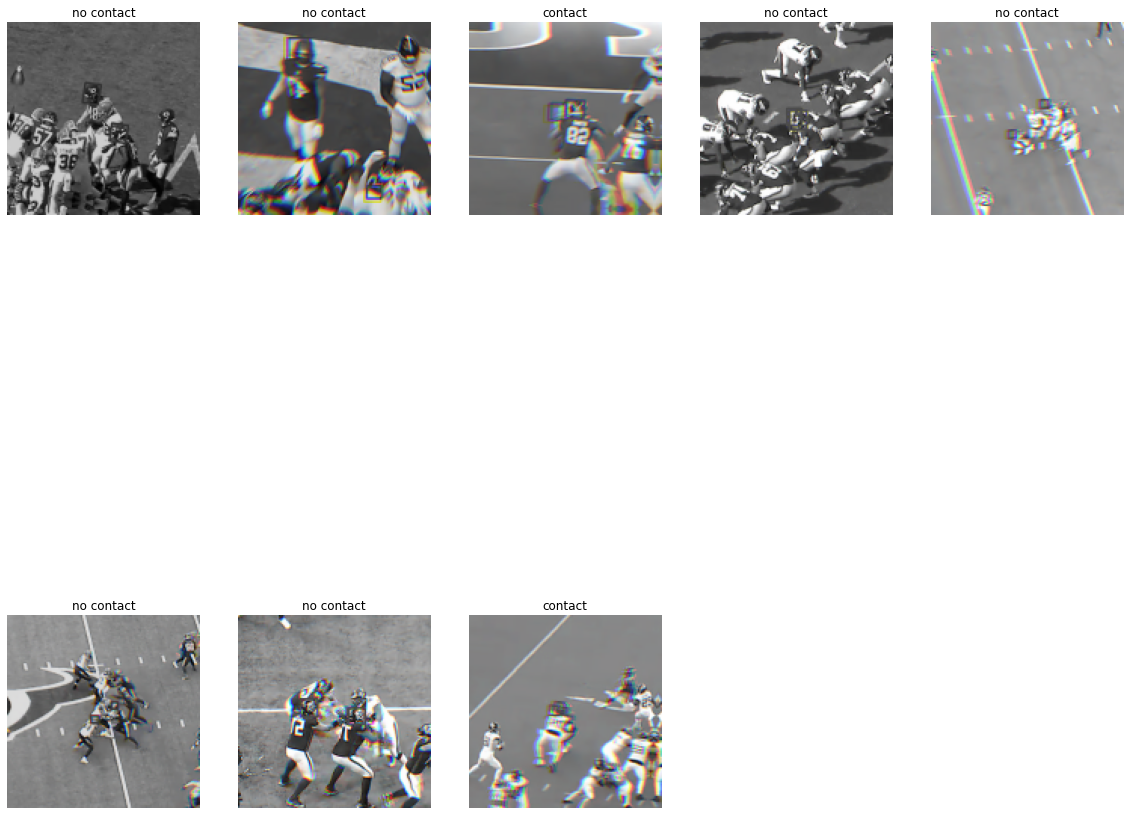

In [91]:
ds = NFL25DDataset(steps_df.query('left_1_na == 0 and left_2_na == 0'), transform=transform, helmets=True, crop_size=256)

loader = DataLoader(
    ds, batch_size=8, shuffle=True, num_workers=8, pin_memory=True,
)

batch = next(iter(loader))

visualize_batch(batch, mean, std)

Now the last thing remaining is to package the dataframe creation steps

### Packaing some functions

In [10]:
def get_steps_df(df_combo, video_metadata, helmets, filter_views=None):    
    players_combo = df_combo.query('nfl_player_id_2 != "G" and distance <= 2').copy()
    
    if filter_views is not None:
        players_combo = players_combo.query('view in @filter_views').copy()

    players_tracking_helmets = pd.DataFrame()

    for gp in tqdm(players_combo.game_play.unique()):
        players_tracking_helmets = pd.concat([players_tracking_helmets,
                                              merge_tracking_and_helmets_ts(players_combo, helmets, video_metadata, gp, 'Sideline'),
                                              merge_tracking_and_helmets_ts(players_combo, helmets, video_metadata, gp, 'Endzone')])
        
    players_tracking_helmets = calc_two_players_helmets_center(players_tracking_helmets)
    
    players_tracking_helmets['left_1_na'] = players_tracking_helmets.left_1.isna()
    players_tracking_helmets['left_2_na'] = players_tracking_helmets.left_2.isna()
        
    agg_dict = {'game_play': 'first',
            'step': 'first',
            'nfl_player_id_1': 'first',
            'nfl_player_id_2': 'first',
            'contact': 'first',
            'distance': 'first',
            'frame': lambda x: list(x),
            'center_x': 'mean',
            'center_y': 'mean',
            'left_1_na': 'sum',
            'left_2_na': 'sum'}

    steps_df = players_tracking_helmets.groupby(['contact_id', 'view']).agg(agg_dict).reset_index()
    
    return steps_df

And now let's create a function to split train and test

In [11]:
def split_df(df_combo, kf_dict, split, sample_train=None, sample_val=None, undersample_no_contact=False, seed=42):
    
    set_seed(seed, True)
    
    train_game_plays = kf_dict[split]['train_games']
    val_game_plays = kf_dict[split]['val_games']
    
    train_combo = df_combo.query('game_play in @train_game_plays').copy()
    val_combo = df_combo.query('game_play in @val_game_plays').copy()
    
    train_combo['is_valid'] = False
    val_combo['is_valid'] = True
    
    if sample_train is not None:
        train_combo = train_combo.sample(frac=sample_train, random_state=seed)
        
    if sample_val is not None:
        val_combo = val_combo.sample(frac=sample_val, random_state=seed)
        
    if undersample_no_contact:
        train_combo = pd.concat([
            train_combo.query('contact == 1'),
            train_combo.query('contact == 0').sample(
                len(train_combo.query('contact == 1')), random_state=seed
            )
        ])

    return train_combo, val_combo

### Comparison

Now in this part, I need to make a comparison between single frame and 2.5D using this approach.

I need the data to be the exact same between both 2.5D and single frame, in order to be able to hold a direct comparison and see which is better.

I can also filter for a specific view, or sample a small part (10% for example), and train over the same number of epochs to see if there is a difference.

I'll first create a steps dataframe, then create a psuedo frames df based on the contact ids in the steps dataframe, and split them both into train and val.

In [12]:
tr_helmets = pd.read_csv(BASE_DIR/"train_baseline_helmets.csv")

tr_video_metadata = pd.read_csv(
    BASE_DIR/"train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)

In [13]:
steps_df = get_steps_df(df_combo, tr_video_metadata, tr_helmets)

  0%|          | 0/240 [00:00<?, ?it/s]

In [14]:
steps_df = steps_df.query('left_1_na == 0 and left_2_na == 0')
steps_df['contact_id_view'] = steps_df['contact_id'] + steps_df['view']

In [15]:
train_steps_df, val_steps_df = split_df(steps_df, kf_dict, split=0, undersample_no_contact=True, seed=42)

In [16]:
train_steps_df.shape, val_steps_df.shape

((128878, 15), (75762, 15))

In [21]:
frames_df = df_combo_with_helmets[(df_combo_with_helmets.left_1.notnull()) & (df_combo_with_helmets.left_2.notnull())].copy()
frames_df.shape

(2404242, 31)

In [22]:
frames_df['contact_id_view'] = frames_df['contact_id'] + frames_df['view']

In [23]:
contact_ids = set(list(train_steps_df.contact_id_view.unique()) + list(val_steps_df.contact_id_view.unique()))

In [24]:
frames_df = frames_df.query('contact_id_view in @contact_ids')

In [25]:
agg_dict = {c: 'first' for c in frames_df.columns if c not in ['contact_id_view']}

frames_df = frames_df.groupby('contact_id_view').agg(agg_dict).reset_index()

frames_df.shape

(204636, 32)

In [26]:
train_frames_df, val_frames_df = split_df(frames_df, kf_dict, split=0)

In [28]:
train_frames_df.shape, val_frames_df.shape

((128876, 33), (75760, 33))

Now let's begin with the frame classification to make the baseline.

#### Frame Model

In [43]:
from torch.utils.data import Dataset, DataLoader
import functools

def add_helmets(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left_1), int(row.top_1)),
                          (int(row.left_1+row.width_1), int(row.top_1+row.height_1)),
                          (255, 0, 0), 2)
    
    if not np.isnan(row.left_2):
        frame = cv2.rectangle(frame, 
                              (int(row.left_2), int(row.top_2)),
                              (int(row.left_2+row.width_2), int(row.top_2+row.height_2)),
                              (255, 0, 0), 2)
    return frame

@functools.lru_cache(maxsize=1250)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


class NFLFrameDataset(Dataset):
    def __init__(self, frames_df, transform=None, crop_size=256, helmets=True):
        self.frames_df = frames_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        
    def __len__(self):
        return len(self.frames_df)
        
    def __getitem__(self, idx):
        row = self.frames_df.iloc[idx]
        frame_path = get_frame_path(int(row.frame), CFG.frames_path, row['game_play'], row['view'])
        frame = self.get_frame(frame_path)
        if self.helmets:
            frame = add_helmets(frame, row)
            # frame = add_helmet_heatmap(frame, row)
            
        frame = crop_frame(frame, row.center_x, row.center_y, self.crop_size)
        if self.transform is not None:
            frame = self.transform(image=frame)['image']
        return frame, row.contact
            
    def get_video_readers(self, frames_df, vids_path, views, h, w, ctx):
        video_readers = {}
        for gp in frames_df.game_play.unique():
            for view in views:
                # Each value will contain the video reader and the last seeked frame
                video_readers[(gp, view)] = [VideoReader((BASE_DIR/'train'/f'{gp}_{view}.mp4').as_posix(), ctx=ctx, height=h, width=w), 0]
        return video_readers
    
    def get_frame(self, path):
        return _get_frame(path)
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds, dtype=batch_tensor.dtype).view(3, 1, 1) + torch.tensor(means, dtype=batch_tensor.dtype).view(3, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        plt.imshow(batch_np[i])
        plt.title(['no contact', 'contact'][batch[1][i].item()])
        plt.axis("off")
    plt.show()

In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

In [45]:
set_seed(42, True)

train_ds = NFLFrameDataset(train_frames_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFLFrameDataset(val_frames_df, transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [40]:
import wandb
from fastai.callback.wandb import *

In [33]:
name = 'frame-pp-nonulls-128'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [46]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model, model_info = create_timm_model('convnext_tiny', n_out=2, n_in=3)
learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        # SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [47]:
learn.fine_tune(3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.528513,0.486456,0.765483,0.474338,0.807470,0.463130,0.588641,07:13


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.433844,0.452844,0.781481,0.511679,0.838531,0.485081,0.614615,07:48
1,0.389147,0.373270,0.829607,0.564291,0.793559,0.563967,0.659348,07:01
2,0.371274,0.367306,0.828986,0.571574,0.813123,0.561078,0.663987,07:04


#### 2.5D

In [31]:
from torch.utils.data import Dataset, DataLoader
import functools

@functools.lru_cache(maxsize=1250)
def _get_frame(path):
    frame = cv2.imread(path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


def get_frame_path(frame_no, frames_path, game_play, view):
    frame = frame_no if len(str(frame_no)) > 3 else f'0{frame_no}'
    return f'{frames_path}/{game_play}_{view}.mp4_{frame}.jpg'


def add_helmet(frame, row):
    frame = frame.copy()
    frame = cv2.rectangle(frame, 
                          (int(row.left), int(row.top)),
                          (int(row.left+row.width), int(row.top+row.height)),
                          (255, 0, 0), 2)
    return frame


class NFL25DDataset(Dataset):
    def __init__(self, steps_df, transform=None, crop_size=256, helmets=True):
        self.steps_df = steps_df
        self.helmets = helmets
        self.crop_size = crop_size
        self.transform = transform
        self.gps_helmet_dfs = {gp: tr_helmets.query('game_play == @gp') for gp in steps_df.game_play.unique()}
        
    def __len__(self):
        return len(self.steps_df)
        
    def __getitem__(self, idx):
        row = self.steps_df.iloc[idx]
        gp = row['game_play']
        view = row['view']
        
        player_1_id = int(row.nfl_player_id_1)
        player_2_id = int(row.nfl_player_id_2)
        
        player_1_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_1_id')
        player_2_helmets = self.gps_helmet_dfs[row.game_play].query('nfl_player_id == @player_2_id')
        
        frames = []
                
        for frame_no in row.frame:
            frame_no = int(frame_no)
            frame_path = get_frame_path(frame_no, CFG.frames_path, gp, view)
            frame = self.get_frame(frame_path)
            
            if self.helmets:
                player_1_frame_helmet = player_1_helmets.query('frame == @frame_no and view == @view')
                player_2_frame_helmet = player_2_helmets.query('frame == @frame_no and view == @view')
                
                frame = add_helmet(frame, player_1_frame_helmet)
                frame = add_helmet(frame, player_2_frame_helmet)
                
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                
            frames.append(frame)
            
        if len(frames) < 6:
            frames = frames + frames[-1:]*(6-len(frames))
            
        frames = np.stack(frames, axis=-1)
        frames = crop_frame(frames, row.center_x, row.center_y, self.crop_size)
        
        if self.transform is not None:
            frames = self.transform(image=frames)['image']
            
        return frames, row.contact
            
    
    def get_frame(self, path):
        return _get_frame(path)
    
    
    
def crop_frame(frame, x, y, size):
    size = size // 2
    
    if y-size < 0:
        min_y = 0
        max_y = min_y + 2*size
        
    elif y+size > 719:
        min_y = 719 - 2*size
        max_y = 719
        
    else:
        min_y = y - size
        max_y = y + size
    
    if x-size < 0:
        min_x = 0
        max_x = min_x + 2*size
        
    elif x+size > 1279:
        min_x = 1279 - 2*size
        max_x = 1279
        
    else:
        min_x = x - size
        max_x = x + size
        
    cropped_frame = frame[int(min_y):int(max_y), 
                          int(min_x):int(max_x), :]
    return cropped_frame
    
def visualize_batch(batch, means, stds):
    """
    Visualize a batch of image data using Matplotlib.
    
    Parameters:
        - batch_tensor (torch.Tensor): A batch of image data in the shape (batch_size, channels, height, width).
        - means (tuple): A tuple of means for each channel in the image data.
        - stds (tuple): A tuple of standard deviations for each channel in the image data.
    """
    # Make a copy of the batch tensor so that we don't modify the original data
    batch_tensor = batch[0].clone()
    
     # Get batch channels no
    channels = batch_tensor.shape[1]
    
    # De-normalize the data using the means and stds
    batch_tensor = batch_tensor * torch.tensor(stds[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1) + torch.tensor(means[:channels], dtype=batch_tensor.dtype).view(channels, 1, 1)
    
    # Convert the data to numpy and transpose it to (batch_size, height, width, channels)
    batch_np = batch_tensor.numpy().transpose(0, 2, 3, 1)
    
    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(batch_np.shape[0]):
        plt.subplot(batch_np.shape[0] // 5 + 1, 5, i + 1)
        
        n_c = batch_np.shape[-1]
        if n_c == 3 or n_c == 1:
            plt.imshow(batch_np[i])
        else:
            plt.imshow(batch_np[i][..., [1, 2, 3]])
            
        plt.title(['no contact', 'contact'][batch[1][i].item()])
        plt.axis("off")
    plt.show()

In [34]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [0.485, 0.456, 0.406]*2
std = [0.229, 0.224, 0.225]*2

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        A.RandomCrop(192, 192),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

In [49]:
train_ds = NFL25DDataset(train_steps_df, transform=train_transform, helmets=True, crop_size=256)
val_ds = NFL25DDataset(val_steps_df, transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True,
)

In [36]:
name = '2.5D-pp-nonulls-192'
wandb.init(project='nfl-1st-and-future', group='frame-vs-2.5D-vs-3D', name=name, force=True)

NameError: name 'wandb' is not defined

In [50]:
seed = 42
set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model, model_info = create_timm_model('convnext_tiny', n_out=2, n_in=6)
learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        # WandbCallback(log_preds=False, seed=seed),
                        # SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [51]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time


KeyboardInterrupt: 

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        # A.VerticalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

In [13]:
frames_df = get_frames_df(df_combo_with_helmets[(df_combo_with_helmets.left_2.notnull()) | (df_combo_with_helmets.nfl_player_id_2 == "G")].copy(),
                      kf_dict, 0, frames_path=CFG.frames_path, sample_every_n_frame=6, sample_every_n_frame_val=6, sample_train=None,
                      sample_val=None, undersample_no_contact=True).copy()

train_ds = NFLFrameDataset(frames_df.query('~is_valid'), transform=train_transform, helmets=True, crop_size=256)
val_ds = NFLFrameDataset(frames_df.query('is_valid'), transform=val_transform, helmets=True, crop_size=256)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8, pin_memory=True,
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True,
)

In [14]:
import wandb
from fastai.callback.wandb import *

In [19]:
name = 'rgb-bbox-1-128'
wandb.init(project='nfl-1st-and-future', group='experiments', name=name, force=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
seed = 42

set_seed(42, True)

data = DataLoaders(train_loader, val_loader)
model, model_info = create_timm_model('convnext_tiny', n_out=2, n_in=3)
learn = Learner(data, model, CrossEntropyLossFlat(), metrics=[accuracy, MatthewsCorrCoef(), Recall(), Precision(), F1Score()],
                cbs=[
                        WandbCallback(log_preds=False, seed=seed),
                        SaveModelCallback(monitor='matthews_corrcoef', fname=name),
                        # MixUp()
                ]
               ).to_fp16()

In [21]:
learn.fine_tune(5, 1e-3)

Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.372372,0.329743,0.861753,0.544188,0.867731,0.424147,0.569784,08:51


Better model found at epoch 0 with matthews_corrcoef value: 0.544187777777841.
Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,recall_score,precision_score,f1_score,time
0,0.298396,0.290470,0.856266,0.555106,0.911248,0.417071,0.572235,08:36
1,0.270638,0.297425,0.868365,0.570167,0.898674,0.439441,0.590254,08:48
2,0.245000,0.274662,0.880273,0.583032,0.877800,0.464340,0.607385,08:33
3,0.185091,0.254028,0.896130,0.604804,0.851965,0.504582,0.633794,08:47
4,0.154786,0.272246,0.894845,0.603095,0.854617,0.500965,0.631659,08:40


Better model found at epoch 0 with matthews_corrcoef value: 0.555105766899305.
Better model found at epoch 2 with matthews_corrcoef value: 0.5830320237619038.
Better model found at epoch 3 with matthews_corrcoef value: 0.6048038927804101.
